In [1]:
#!pip install numpy 
#!pip install pandas
#!pip install keras
#!pip install tensorflow-gpu
#!pip install seaborn
#!pip install sklearn
#!pip install string
#!pip install nltk
#!pip install wordcloud
#!pip install collections
!pip install keras-tuner


     |████████████████████████████████| 71kB 8.0MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=3d5261e506777dc4e838a3fe9a4b4f927c97ddccf6d30d291a58344918a587d8
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=8251d2589b7a3726a038b2eb7839dc77957d94cc244c9fc84f0dec65494e3d27
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import math
import copy
import seaborn as sns
import re 
import keras.backend as K
from sklearn.model_selection import train_test_split
from processing import Text_processing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Activation, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold
from string import punctuation
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import sklearn
import kerastuner as kt
from kerastuner import HyperModel
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
def punctuation_stopwords_removal(seq):
      """[Function to remove punctation and stopwords from sequences]

      Args:
          seq [str]: [Unprocessed text sequence]

      Returns:
          [str]: [Text sequence without punctuation and stopwords]
      """    
      # filters charecter-by-charecter : ['h', 'e', 'e', 'l', 'o', 'o', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'p', 'u', 'r', 'v', 'a']
      remove_punctuation = [ch for ch in seq if ch not in punctuation]
      # convert them back to sentences and split into words
      remove_punctuation = "".join(remove_punctuation).split()
      filtered_seq = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
      return filtered_seq

def word_counter(df,number_words):
      """[Function that counts each instance of a word in a dataframe]

      Args:
          df ([pandas.Dataframe]): [dataframe containing either real or fake news]
          number_words ([int]): [number of words to be returned]

      Returns:
          [pandas.Dataframe]: [dataframe for the most common words in the dataframe provided ann their counts]
      """    
      df_1 = df.copy(deep = True)
      df_1.loc[:, 'content'] = df_1['content'].apply(punctuation_stopwords_removal)
      df_1_curated = df_1['content'].tolist()
      loc_tweet_list = []
      for sublist in df_1_curated:
          for word in sublist:
              loc_tweet_list.append(word)
      loc_tweet_count = Counter(loc_tweet_list)
      loc_top_words = pd.DataFrame(loc_tweet_count.most_common(number_words), columns=['word', 'count'])

      return loc_top_words

def remove_word(df, word):
      """[Function to remove a specific word from a dataframe]

      Args:
          df ([pandas.Dataframe]): [dataframe to be altered]
          word ([str]): [word to be removed from the dataframe]
      """
      df['content'].replace(word,'',regex=True, inplace = True)
      df['title'].replace(word,'',regex=True, inplace = True)
      
def common_words(df_f,df_r):
      """[Function that determines the common words between 2 dataframes of real_news and fake_news]

      Args:
          df_f ([pandas.Dataframe]): [Dataframe of fake_news]
          df_r ([pandas.Dataframe]): [Dataframe of real_news]

      Returns:
          [list]: [List of the common words between the 2 dataframes]
      """    
      a = word_counter(df_f,50)
      b = word_counter(df_r,50)
      common=[]
      for word in a['word']:
          if word in b['word'].tolist():
              common.append(word)
      return common

def remove_common(common,dfs_list):
      """[Function to remove common words from dataframes provided]

      Args:
          common ([list]): [list of common words between real and fake news]
          dfs_list ([list]): [List of dataframes to be changed]
      """    
      for df in dfs_list:
          for word in common:
              remove_word(df,word)

In [6]:
path = '/content/drive/MyDrive/Trabalho_SIB'
treated_reals_05 = pd.read_csv(path+'/treated_reals_05.csv',index_col=0)
treated_fakes_05 = pd.read_csv(path+'/treated_fakes_05.csv',index_col=0)
treated_reals_07 = pd.read_csv(path+'/treated_reals_07.csv',index_col=0)
treated_fakes_07 = pd.read_csv(path+'/treated_fakes_07.csv',index_col=0)
treated_reals_09 = pd.read_csv(path+'/treated_reals_09.csv',index_col=0)
treated_fakes_09 = pd.read_csv(path+'/treated_fakes_09.csv',index_col=0)
treated_reals_11 = pd.read_csv(path+'/treated_reals_11.csv',index_col=0)
treated_fakes_11 = pd.read_csv(path+'/treated_fakes_11.csv',index_col=0)

all_reals = pd.concat([treated_reals_05,treated_reals_07,treated_reals_09,treated_reals_11])
all_fakes = pd.concat([treated_fakes_05,treated_fakes_07,treated_fakes_09,treated_fakes_11])

co = common_words(all_reals,all_fakes)
remove_common(co,[treated_reals_05,treated_fakes_05,treated_reals_07,treated_fakes_07,
                  treated_reals_09,treated_fakes_09,treated_reals_11,treated_fakes_11])

print('Number of real news:' ,all_reals.shape[0])
print('Number of fake news:' ,all_fakes.shape[0])

Number of real news: 4024
Number of fake news: 416


In [ ]:
def get_metrics(Y_true, Y_pred):
      """[Function to print the specified metrics]

      Args:
          Y_true ([Array]): [List of classifications known to be true]
          Y_pred ([Array]): [List of classifications predicted by the model]
      """    
      f1 = f1_score(Y_true, Y_pred)
      acc = accuracy_score(Y_true, Y_pred)
      recall = recall_score(Y_true, Y_pred)
      mcc = matthews_corrcoef(Y_true, Y_pred)
      confusion_mat = confusion_matrix(Y_true, Y_pred)
      print('------------------------------Metrics for model------------------------------')
      print('Confusion Matrix:')
      print(confusion_mat)
      print('-----------------------------------------------------------------------------')
      print('Accuracy: %f' %acc)
      print('-----------------------------------------------------------------------------')
      print('Recall: %f' %recall)
      print('-----------------------------------------------------------------------------')
      print('Matthews Correlation Coeficient: %f' %mcc)
      print('-----------------------------------------------------------------------------')
      print('F1-Score: %f' %f1)

In [ ]:
#declaring dict to store all the words as keys in the dictionary and their vector representations as values
glove_vectors = dict()
file = open(path+'/glove.6B.100d.txt', encoding='utf-8')
for line in file:
      values = line.split()
      word = values[0]
      #storing the word in the variable
      vectors = np.asarray(values[1: ])
      #storing the vector representation of the respective word in the dictionary
      glove_vectors[word] = vectors
file.close()

In [ ]:
def downsample(reals,fakes, multiple = False):
      """[Function to downsample real data]

      Args:
          reals ([pandas.Dataframe]): [Dataframe of real news]
          fakes ([pandas.Dataframe]): [Dataframe of fake news]
          multiple (bool, optional): [If multiple downsampled dataframes are to be created, it should be set to True]. Defaults to False.

      Returns:
          [list/pandas.Dataframe]: [dataframe or list of dataframes, containing the real and fake news in the same proportion]
      """    
      data = None
      if multiple:
          data=[]
          for i in range(math.floor(reals.shape[0]/fakes.shape[0])):
              data.append(pd.concat([reals.sample(n=fakes.shape[0]),fakes],axis=0))
      else:
          data = pd.concat([reals.sample(n=fakes.shape[0]),fakes],axis=0)
      return data

In [ ]:
def matthews_correlation(y_true, y_pred):
      """[Auxliary metric funtion to be used with keras model]

      Args:
          y_true ([Array]): [Real classification values]
          y_pred ([Array]): [Predicted classification values]

      Returns:
          [int]: [Matthews Correlation Coeficient value]
      """    
      tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
      fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
      fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

      num = tp * tn - fp * fn
      den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
      return num / K.sqrt(den + K.epsilon())

In [ ]:
def create_matrix_vec(vocab_size,token,dimentions):
      """[Creates a word vector matrix for the vocabulary size of the our dataset]

      Args:
          vocab_size ([int]): [Vocabulary size of dataset]
          token ([Tokenizer instance]): [Tokenizer instance created and used to encode the dataset]
          dimentions ([int]): [Embedding vector size]

      Returns:
          [tuple]: [tuple of matrix and misspelled words list]
      """    
      misspelled = []
      word_vector_matrix = np.zeros((vocab_size, dimentions))
      for word, index in token.word_index.items():
          vector = glove_vectors.get(word)
          if vector is not None:
              word_vector_matrix[index] = vector
          else:
              misspelled.append(word)        
      return (word_vector_matrix,misspelled)

In [ ]:
def create_new_model(vocab_size,max_length, word_vector_matrix,vec_size=100):
      """[Creates a new Keras model with the given architecture]

      Args:
          vocab_size ([int]): [Vocabulary size of the training data]
          max_length ([int]): [Number of words to be included]
          word_vector_matrix ([type]): [Word vector matrix for the training data]
          vec_size (int, optional): [Embedding vector size]. Defaults to 100.

      Returns:
          [type]: [Keras model instance]
      """    
      model = Sequential()
      model.add(Embedding(input_dim=vocab_size,output_dim=vec_size,input_length=max_length, weights = [word_vector_matrix] , trainable = False))
      model.add(LSTM(1500,activation='swish'))
      model.add(Dense(750,activation='relu'))
      model.add(Dense(300, activation ='relu' ))
      model.add(Dense(1,activation='sigmoid'))
      return model

In [ ]:
def get_model_name(k):
      """[Auxiliary function to retrieve name of previously saved and optimized model]
      """    
      return 'model_'+str(k)+'.h5'

In [ ]:
def prepare_data(dataset, mode = 'b'):
      """[Prepares a dataset, given that it has 3 collumns initially ('content','title','State'), to be returned with only two columns]

      Args:
          dataset ([pandas.Dataframe]): [dataset to be prepared]
          mode (str, optional): [Can be one of 3 values. 'b' stands for both in wich both the contents and titles are renamed to only contents.
                                                        'c' stands for only contents, in which the column of titles is droped
                                                        't  stands for only titles, in which the contents are dropped and the titles column is renamed to contents.]. Defaults to 'b'.

      Returns:
          [pandas.Dataframe]: [Dataframe prepared to be encoded]
      """    
      if mode == 'b':
          contents_state = dataset[['content','State']]
          titles_state = dataset[['title','State']]
          titles_state=titles_state.rename(columns={'title':'content','State':'State'})
          Full = pd.concat([contents_state,titles_state],axis=0)
      elif mode == 't':
          Full = dataset[['title','State']]
          Full = Full.rename(columns = {'title':'content','State':'State'})
      elif mode == 'c':
          Full = dataset[['content','State']]
      return Full

In [ ]:
def prepare_full_dataset(dataset,token_obj=None,max_len = 30, mode = 'b'):
      """[Encodes a dataset, preparing them to be used with keras models]

      Args:
          dataset ([pandas.Dataframe]): [Dataframe to be encoded]
          token_obj ([Tokenizer instance], optional): [In case the dataset is the training one, token should be none, and an intance will be created,
                                                      otherwise the resulting tokenizer intance from the training should be passed as
                                                      argument, when preparing validation and testing dataset]. Defaults to None.
          max_len (int, optional): [Number of words of training data]. Defaults to 30.
          mode (str, optional): [Mode of use of prepare_data function]. Defaults to 'b'.      

      Returns:
          [tuple]: [X datset (encoded) ,Y dataset (labels), word matrix, vocabulary size, tokenizer instance]
      """    
      if token_obj: 
        ## Reshape and concat titles and contents together, in order to get X(column 'content') and Y('State')
        Full = prepare_data(dataset,mode)
        text = Full['content'].tolist()
        Y = Full['State']
        ## Pre-process content columns text
        pre_processed_text = Text_processing(text, run_all=True)
        pre_processed_text = pre_processed_text.get_processed_text()
        ## Get encodings for each of the sequences of contents column
        X, vocab_size, token = encoding(pre_processed_text,token_obj=token_obj,max_length=max_len)
        ## Create word_vector matrix 
        matrix = None
      else:
          ## Reshape and concat titles and contents together, in order to get X(column 'content') and Y('State')
          Full = prepare_data(dataset,mode)
          text = Full['content'].tolist()
          Y = Full['State']
          ## Pre-process content columns text
          pre_processed_text = Text_processing(text, run_all=True)
          pre_processed_text = pre_processed_text.get_processed_text()
          ## Get encodings for each of the sequences of contents column
          X, vocab_size, token = encoding(pre_processed_text,token_obj=token_obj,max_length=max_len)
          ## Create word_vector matrix 
          matrix , misspled= create_matrix_vec(vocab_size, token, dimentions = 100)
            
      return (X, Y, matrix, vocab_size, token)

In [ ]:
def encoding(text, max_length = 30, pad = 'post',token_obj = None):
      """[Encondes the sequences of processed text]

      Args:
          text ([str]): [Preprocessed sequences]
          max_length (int, optional): [maximum number of words to be encoded for each sequence]. Defaults to 30.
          pad (str, optional): [type of padding to be applied when the number of words of the sequence is less than max_length]. Defaults to 'post'.
          token_obj ([type], optional): [tokenizer instance. it should always be the one resulting from training data]. Defaults to None.

      Returns:
          [tuple]: [encoded text sequences (X), vocabulary size for the sequences, and tokenizer instance]
      """    
      X = None
      vocab_size = None 
      token = token_obj
      if token:
          encoded_text = token.texts_to_sequences(text)
          X = pad_sequences(encoded_text, maxlen=max_length, padding=pad)
      else:
          token = Tokenizer()
          token.fit_on_texts(text)

          vocab_size = len(token.word_index) + 1

          encoded_text = token.texts_to_sequences(text)
          X = pad_sequences(encoded_text, maxlen=max_length, padding=pad)
      return (X, vocab_size, token)

In [ ]:
def val_down_data(list_data,dataset_val,data_test, max_words = 30,mod = 'b'):
      """[For each testing data resulting of the dowsampling process, creates a new model which will be fitted to the same validation data, and evaluted with the same testing data.
          This was created to determine which of the best training dataset yielded the best resuslts]

      Args:
          list_data ([list]): [Trainging datasets]
          dataset_val ([pandas.Dataframe]): [Validation dataset]
          data_test ([pandas.Dataframe]): [Test dataset]
          max_words (int, optional): [maximum number of words of the input]. Defaults to 30.
          mod (str, optional): [mode for the prepare_data function]. Defaults to 'b'.

      Returns:
          [int]: [index of the best model that resulted from this process]
      """    
      save_dir = '/saved_models/'
      fold_var = 0
      best_mcc = 0
      best_model = -1
      for i in list_data:        
          X_train, Y_train, Train_matrix, vocab, train_token = prepare_full_dataset(i,mode = mod ,max_len=max_words)
          X_val , Y_val, Val_matrix, Y_vocab, useless = prepare_full_dataset(dataset_val,token_obj=train_token,mode = mod,max_len=max_words)
          X_test , Y_test , test_matrix, test_vocab, useless_2 = prepare_full_dataset(data_test, token_obj=train_token,mode = mod,max_len=max_words)

          model = create_new_model(vocab_size = vocab , max_length=max_words , word_vector_matrix= Train_matrix)

          model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy',matthews_correlation])

          es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
          checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                                          monitor='val_matthews_correlation', 
                                                          verbose=1, 
                                                          save_best_only=True, mode='max')
          callbacks_list = [es_callback,checkpoint]
          history = model.fit(X_train,Y_train,
                      epochs=100,
                      callbacks=callbacks_list,
                      validation_data=(X_val,Y_val))
          acc = history.history['accuracy']
          val_acc = history.history['val_accuracy']
          loss = history.history['loss']
          val_loss = history.history['val_loss']
          epochs = range(1, len(acc) + 1)
          plt.plot(epochs, acc, 'bo', label='Training acc')
          plt.plot(epochs, val_acc, 'b', label='Validation acc')
          plt.title('Training and validation accuracy')
          plt.legend()
          plt.figure()
          plt.plot(epochs, loss, 'bo', label='Training loss')
          plt.plot(epochs, val_loss, 'b', label='Validation loss')
          plt.title('Training and validation loss')
          plt.legend()
          plt.show()
          mcc_val = max(history.history['val_matthews_correlation'])
          if mcc_val > best_mcc:
              best_mcc = mcc_val
              best_model = fold_var
          # LOAD BEST MODEL to evaluate the performance of the model
          model.load_weights(save_dir+"/model_"+str(fold_var)+".h5")
          results = model.evaluate(X_test,Y_test)
          results = dict(zip(model.metrics_names,results))
          print()
          print(results['matthews_correlation'])
          fold_var += 1
      return best_model 

# **Testing with base parameters**
## 30 max words 
## Both titles and contents

In [ ]:
reals = pd.concat([treated_reals_05,treated_reals_07],axis = 0)
fakes = pd.concat([treated_fakes_05,treated_fakes_07],axis = 0)

In [ ]:
down_data = downsample(reals,fakes,multiple=True)

In [ ]:
dataset_val = downsample(treated_reals_09,treated_fakes_09)

In [ ]:
dataset_testing = pd.concat([treated_reals_11,treated_fakes_11])

Epoch 1/100
44/44 [==============================] - 5s 91ms/step - loss: 0.6884 - accuracy: 0.5321 - matthews_correlation: 0.0569 - val_loss: 0.6663 - val_accuracy: 0.6011 - val_matthews_correlation: -0.0028

Epoch 00001: val_matthews_correlation improved from -inf to -0.00283, saving model to /saved_models/model_0.h5
Epoch 2/100
44/44 [==============================] - 4s 85ms/step - loss: 0.6483 - accuracy: 0.6105 - matthews_correlation: 0.2634 - val_loss: 0.6587 - val_accuracy: 0.5851 - val_matthews_correlation: 0.0336

Epoch 00002: val_matthews_correlation improved from -0.00283 to 0.03362, saving model to /saved_models/model_0.h5
Epoch 3/100
44/44 [==============================] - 4s 87ms/step - loss: 0.6381 - accuracy: 0.6401 - matthews_correlation: 0.3253 - val_loss: 0.6050 - val_accuracy: 0.7234 - val_matthews_correlation: 0.1020

Epoch 00003: val_matthews_correlation improved from 0.03362 to 0.10198, saving model to /saved_models/model_0.h5
Epoch 4/100
44/44 [===============

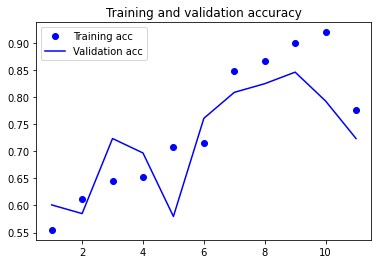

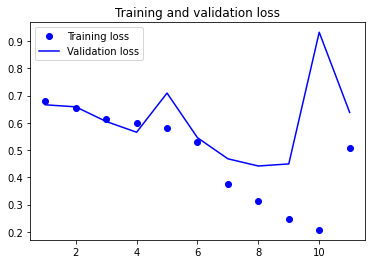

54/54 [==============================] - 1s 12ms/step - loss: 6.2239 - accuracy: 0.8184 - matthews_correlation: 0.0052

0.005232826340943575
Epoch 1/100
44/44 [==============================] - 5s 89ms/step - loss: 0.6728 - accuracy: 0.5490 - matthews_correlation: 0.0862 - val_loss: 0.6503 - val_accuracy: 0.5957 - val_matthews_correlation: -0.0029

Epoch 00001: val_matthews_correlation improved from -inf to -0.00292, saving model to /saved_models/model_1.h5
Epoch 2/100
44/44 [==============================] - 4s 84ms/step - loss: 0.6392 - accuracy: 0.6224 - matthews_correlation: 0.2954 - val_loss: 0.6580 - val_accuracy: 0.6117 - val_matthews_correlation: 0.0432

Epoch 00002: val_matthews_correlation improved from -0.00292 to 0.04324, saving model to /saved_models/model_1.h5
Epoch 3/100
44/44 [==============================] - 4s 83ms/step - loss: 0.6309 - accuracy: 0.6199 - matthews_correlation: 0.2818 - val_loss: 0.6652 - val_accuracy: 0.6064 - val_matthews_correlation: 0.0167

Epoch 

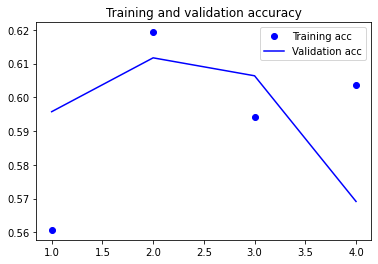

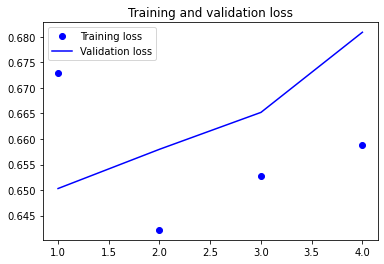

54/54 [==============================] - 1s 12ms/step - loss: 0.6634 - accuracy: 0.2165 - matthews_correlation: 0.0024

0.0023832395672798157
Epoch 1/100
44/44 [==============================] - 5s 90ms/step - loss: 0.6864 - accuracy: 0.5478 - matthews_correlation: 0.0860 - val_loss: 0.6758 - val_accuracy: 0.5851 - val_matthews_correlation: 0.0462

Epoch 00001: val_matthews_correlation improved from -inf to 0.04623, saving model to /saved_models/model_2.h5
Epoch 2/100
44/44 [==============================] - 4s 85ms/step - loss: 1.7005 - accuracy: 0.5937 - matthews_correlation: 0.2471 - val_loss: 0.6791 - val_accuracy: 0.5904 - val_matthews_correlation: 0.0058

Epoch 00002: val_matthews_correlation did not improve from 0.04623
Epoch 3/100
44/44 [==============================] - 4s 83ms/step - loss: 0.6734 - accuracy: 0.5938 - matthews_correlation: 0.2224 - val_loss: 0.6537 - val_accuracy: 0.6011 - val_matthews_correlation: 0.0192

Epoch 00003: val_matthews_correlation did not improve 

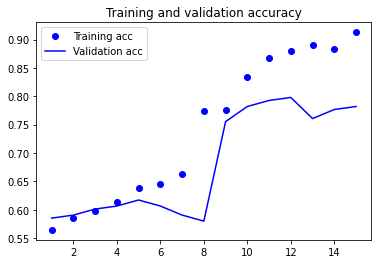

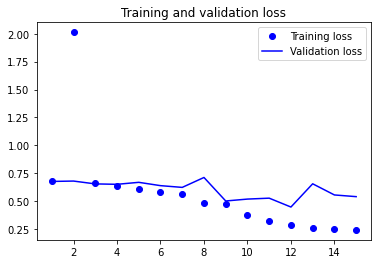

54/54 [==============================] - 1s 12ms/step - loss: 0.6795 - accuracy: 0.7311 - matthews_correlation: 0.0012

0.001248158747330308
Epoch 1/100
44/44 [==============================] - 5s 90ms/step - loss: 0.6768 - accuracy: 0.5620 - matthews_correlation: 0.1521 - val_loss: 0.6431 - val_accuracy: 0.6117 - val_matthews_correlation: 0.0188

Epoch 00001: val_matthews_correlation improved from -inf to 0.01881, saving model to /saved_models/model_3.h5
Epoch 2/100
44/44 [==============================] - 4s 84ms/step - loss: 0.6049 - accuracy: 0.6692 - matthews_correlation: 0.3844 - val_loss: 0.7609 - val_accuracy: 0.5106 - val_matthews_correlation: 0.0248

Epoch 00002: val_matthews_correlation improved from 0.01881 to 0.02476, saving model to /saved_models/model_3.h5
Epoch 3/100
44/44 [==============================] - 4s 84ms/step - loss: 0.6809 - accuracy: 0.5511 - matthews_correlation: 0.1925 - val_loss: 0.6630 - val_accuracy: 0.6117 - val_matthews_correlation: 0.0538

Epoch 000

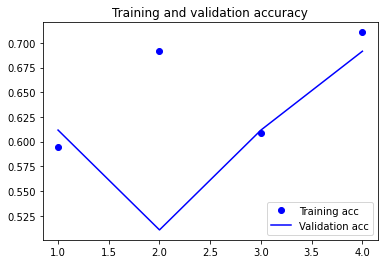

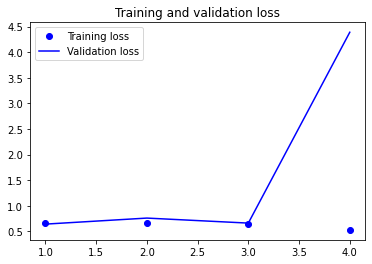

54/54 [==============================] - 1s 12ms/step - loss: 43.4172 - accuracy: 0.6449 - matthews_correlation: 4.3512e-04

0.00043512493721209466
Epoch 1/100
44/44 [==============================] - 5s 87ms/step - loss: 0.6800 - accuracy: 0.5288 - matthews_correlation: 0.0790 - val_loss: 0.6679 - val_accuracy: 0.5904 - val_matthews_correlation: 0.0502

Epoch 00001: val_matthews_correlation improved from -inf to 0.05023, saving model to /saved_models/model_4.h5
Epoch 2/100
44/44 [==============================] - 4s 84ms/step - loss: 0.6570 - accuracy: 0.6037 - matthews_correlation: 0.2498 - val_loss: 0.6653 - val_accuracy: 0.5957 - val_matthews_correlation: 0.0167

Epoch 00002: val_matthews_correlation did not improve from 0.05023
Epoch 3/100
44/44 [==============================] - 4s 82ms/step - loss: 0.6334 - accuracy: 0.6687 - matthews_correlation: 0.3574 - val_loss: 0.6559 - val_accuracy: 0.6170 - val_matthews_correlation: 0.0616

Epoch 00003: val_matthews_correlation improved f

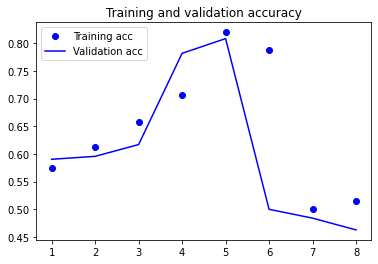

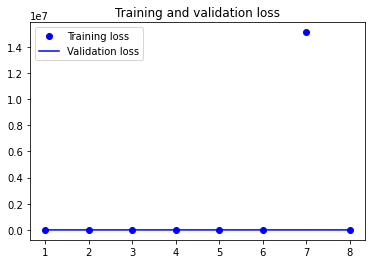

54/54 [==============================] - 1s 12ms/step - loss: 0.5097 - accuracy: 0.7765 - matthews_correlation: 0.0042

0.004195751156657934
Epoch 1/100
44/44 [==============================] - 5s 88ms/step - loss: 0.6711 - accuracy: 0.5367 - matthews_correlation: 0.1024 - val_loss: 0.6837 - val_accuracy: 0.6011 - val_matthews_correlation: 0.0058

Epoch 00001: val_matthews_correlation improved from -inf to 0.00582, saving model to /saved_models/model_5.h5
Epoch 2/100
44/44 [==============================] - 4s 83ms/step - loss: 0.6158 - accuracy: 0.6452 - matthews_correlation: 0.3479 - val_loss: 0.6545 - val_accuracy: 0.5798 - val_matthews_correlation: 0.0218

Epoch 00002: val_matthews_correlation improved from 0.00582 to 0.02183, saving model to /saved_models/model_5.h5
Epoch 3/100
44/44 [==============================] - 4s 84ms/step - loss: 0.6015 - accuracy: 0.6482 - matthews_correlation: 0.3768 - val_loss: 0.5477 - val_accuracy: 0.7181 - val_matthews_correlation: 0.1579

Epoch 000

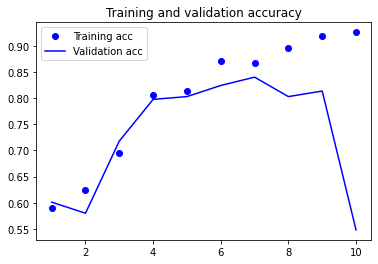

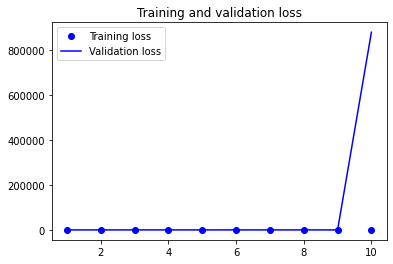

54/54 [==============================] - 1s 12ms/step - loss: 0.2774 - accuracy: 0.8941 - matthews_correlation: 0.0020

0.0020239059813320637


In [ ]:
best = val_down_data(down_data,dataset_val,dataset_testing)

In [ ]:
print('Index do melhor datset de treino: %d' %best)

Index do melhor datset de treino: 5


In [ ]:
X_train, Y_train, Train_matrix, vocab, train_token = prepare_full_dataset(down_data[best])

In [ ]:
X_val , Y_val, Val_matrix, Y_vocab, useless = prepare_full_dataset(dataset_val,token_obj=train_token)

In [ ]:
X_test , Y_test , test_matrix, test_vocab, useless_2 = prepare_full_dataset(dataset_testing, token_obj=train_token)

In [ ]:
class MYHyperModel_dep(HyperModel):
    def __init__(self, vocab, matrix,words):
          """
          Args:
              vocab ([int]): [vocabulary size of Embedding]
              matrix ([type]): [word vector matrix for training data, to be used in Embedding]
              words ([int]): [max number of words for input]
          """        
          self.input_shape = vocab
          self.train_matrix = matrix
          self.input_length = words
            
    def build(self,hp):
          """[Creates model to be used in hyperparameter tunning]

          Args:
              hp ([type]): [hyperparameter class]

          Returns:
              []: [Kerastuner model to be optimized]
          """
          model = tf.keras.Sequential()
          model.add(Embedding(self.input_shape, 100, input_length=self.input_length , weights = [self.train_matrix], trainable = False))
          model.add(LSTM(units=hp.Int('units_lstm_1_' , min_value=10, max_value=1500, step=20), activation=hp.Choice('a_lstm_1', values =['relu','tanh','elu','selu','swish']),return_sequences=False))
          for i in range(hp.Int('num_layers_Dense_1_', 1, 3)):
              model.add(Dense(units=hp.Int('units_dense_1_' + str(i), min_value=10, max_value=1000, step=20), 
                              activation=hp.Choice('a_dense_1'+str(i), values =['relu','tanh','elu','selu','swish']))
          
          model.add(Dense(1, activation='sigmoid'))
          model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',
                              values=[1e-2, 1e-3, 1e-4])),
                      loss = 'binary_crossentropy', metrics=['accuracy',matthews_correlation])
          
          return model


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/model_optim/model.h5', 
                                                        monitor='val_matthews_correlation', 
                                                        verbose=0, 
                                                        save_best_only=True, mode='max')

In [ ]:
with tf.device('/device:GPU:0'):
    hypermodel_dep = MYHyperModel_dep(vocab,Train_matrix,words=30)
    tuner = kt.BayesianOptimization(hypermodel_dep,
                          objective=kt.Objective("val_matthews_correlation", direction="max"),
                          max_trials=25,
                          num_initial_points=2,
                          directory='/content/optim_lstm_4/',
                          project_name='optim_1', seed = 666)
    tuner.search_space_summary()
    es = tf.keras.callbacks.EarlyStopping(patience=5)
    tuner.search(X_train, Y_train, epochs=200, batch_size=50, 
              validation_data=(X_val, Y_val), 
              verbose=0, callbacks=[es, checkpoint])

Search space summary
Default search space size: 6
units_lstm_1_ (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 1500, 'step': 20, 'sampling': None}
a_lstm_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu', 'swish'], 'ordered': False}
num_layers_Dense_1_ (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_dense_1_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 1000, 'step': 20, 'sampling': None}
a_dense_10 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu', 'swish'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps_dep = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
model_dep_lstm = tuner.hypermodel.build(best_hps_dep)
model_dep_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           441300    
_________________________________________________________________
lstm (LSTM)                  (None, 1490)              9482360   
_________________________________________________________________
dense (Dense)                (None, 990)               1476090   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 991       
Total params: 11,400,741
Trainable params: 10,959,441
Non-trainable params: 441,300
_________________________________________________________________


In [ ]:
filepath= '/content/model.h5'
mc_d = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True,monitor='val_matthews_correlation',mode = 'max')
es_d = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)

history_d = model_dep_lstm.fit(X_train, Y_train, epochs=200, batch_size=50, 
                    validation_data=(X_val, Y_val), 
                    callbacks=[mc_d, es_d])

Epoch 1/200
28/28 [==============================] - 2s 61ms/step - loss: 0.0392 - accuracy: 0.9921 - matthews_correlation: 0.9842 - val_loss: 0.9210 - val_accuracy: 0.8404 - val_matthews_correlation: 0.3752
Epoch 2/200
28/28 [==============================] - 2s 60ms/step - loss: 0.0236 - accuracy: 0.9957 - matthews_correlation: 0.9915 - val_loss: 0.9486 - val_accuracy: 0.7926 - val_matthews_correlation: 0.3251
Epoch 3/200
28/28 [==============================] - 2s 60ms/step - loss: 0.0378 - accuracy: 0.9893 - matthews_correlation: 0.9791 - val_loss: 1.3069 - val_accuracy: 0.8298 - val_matthews_correlation: 0.4268
Epoch 4/200
28/28 [==============================] - 2s 61ms/step - loss: 0.0276 - accuracy: 0.9929 - matthews_correlation: 0.9857 - val_loss: 1.0321 - val_accuracy: 0.8138 - val_matthews_correlation: 0.3328
Epoch 5/200
28/28 [==============================] - 2s 60ms/step - loss: 0.0303 - accuracy: 0.9921 - matthews_correlation: 0.9841 - val_loss: 0.8876 - val_accuracy: 0.

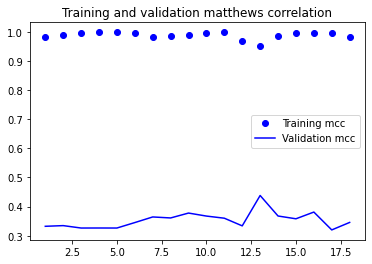

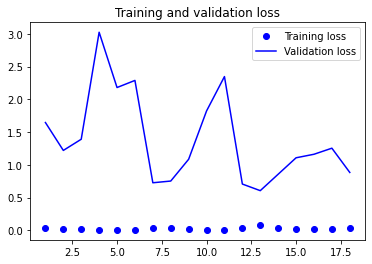

In [ ]:
mcc = history_d.history['matthews_correlation']
val_mcc = history_d.history['val_matthews_correlation']
loss = history_d.history['loss']
val_loss = history_d.history['val_loss']
epochs = range(1, len(mcc) + 1)
plt.plot(epochs, mcc, 'bo', label='Training mcc')
plt.plot(epochs, val_mcc, 'b', label='Validation mcc')
plt.title('Training and validation matthews correlation')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model_dep_lstm.load_weights(filepath)
model_dep_lstm.evaluate(X_test,Y_test)
Y_Predicted = model_dep_lstm.predict_classes(X_test)

54/54 [==============================] - 1s 13ms/step - loss: 0.3618 - accuracy: 0.9139 - matthews_correlation: 0.0105


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
get_metrics(Y_test,Y_Predicted)

------------------------------Metrics for model------------------------------
Confusion Matrix:
[[  28   10]
 [ 138 1542]]
-----------------------------------------------------------------------------
Accuracy: 0.913853
-----------------------------------------------------------------------------
Recall: 0.917857
-----------------------------------------------------------------------------
Matthews Correlation Coeficient: 0.325903
-----------------------------------------------------------------------------
F1-Score: 0.954208


#Testing with increased input words
## 40 words
## Both contents and titles

In [ ]:
reals_40 = pd.concat([treated_reals_05,treated_reals_07],axis = 0)
fakes_40 = pd.concat([treated_fakes_05,treated_fakes_07],axis = 0)

In [ ]:
down_data_40 = downsample(reals_40,fakes_40,multiple=True)

In [ ]:
dataset_val_40 = downsample(treated_reals_09,treated_fakes_09)

In [ ]:
dataset_testing_40 = pd.concat([treated_reals_11,treated_fakes_11])

Epoch 1/100
44/44 [==============================] - 6s 110ms/step - loss: 0.6785 - accuracy: 0.5392 - matthews_correlation: 0.0919 - val_loss: 0.6727 - val_accuracy: 0.5532 - val_matthews_correlation: 0.0070

Epoch 00001: val_matthews_correlation improved from -inf to 0.00704, saving model to /saved_models/model_0.h5
Epoch 2/100
44/44 [==============================] - 5s 105ms/step - loss: 0.6947 - accuracy: 0.6050 - matthews_correlation: 0.2688 - val_loss: 0.6822 - val_accuracy: 0.5479 - val_matthews_correlation: 0.0244

Epoch 00002: val_matthews_correlation improved from 0.00704 to 0.02439, saving model to /saved_models/model_0.h5
Epoch 3/100
44/44 [==============================] - 5s 105ms/step - loss: 0.6418 - accuracy: 0.6011 - matthews_correlation: 0.2610 - val_loss: 0.6869 - val_accuracy: 0.5372 - val_matthews_correlation: -0.0050

Epoch 00003: val_matthews_correlation did not improve from 0.02439
Epoch 4/100
44/44 [==============================] - 5s 104ms/step - loss: 0.61

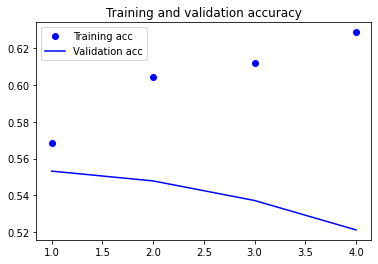

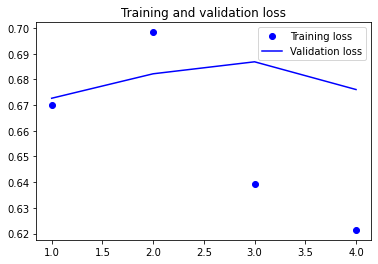

54/54 [==============================] - 1s 16ms/step - loss: 0.5913 - accuracy: 0.9366 - matthews_correlation: -0.0064

-0.006388978101313114
Epoch 1/100
44/44 [==============================] - 6s 110ms/step - loss: 0.6838 - accuracy: 0.5468 - matthews_correlation: 0.1246 - val_loss: 0.6727 - val_accuracy: 0.5585 - val_matthews_correlation: 0.0296

Epoch 00001: val_matthews_correlation improved from -inf to 0.02955, saving model to /saved_models/model_1.h5
Epoch 2/100
44/44 [==============================] - 5s 107ms/step - loss: 0.7245 - accuracy: 0.6258 - matthews_correlation: 0.3128 - val_loss: 0.6788 - val_accuracy: 0.5638 - val_matthews_correlation: 0.0380

Epoch 00002: val_matthews_correlation improved from 0.02955 to 0.03797, saving model to /saved_models/model_1.h5
Epoch 3/100
44/44 [==============================] - 5s 103ms/step - loss: 0.6399 - accuracy: 0.6169 - matthews_correlation: 0.2804 - val_loss: 0.7636 - val_accuracy: 0.5638 - val_matthews_correlation: 0.0575

Epoc

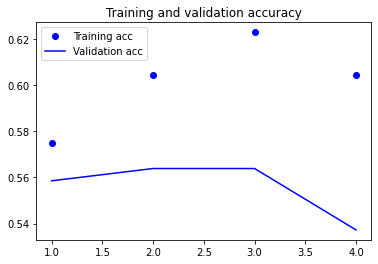

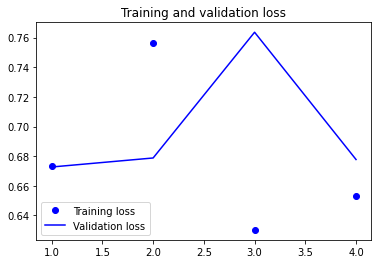

54/54 [==============================] - 1s 16ms/step - loss: 0.9099 - accuracy: 0.1542 - matthews_correlation: 0.0040

0.0040209670551121235
Epoch 1/100
44/44 [==============================] - 6s 110ms/step - loss: 0.6769 - accuracy: 0.5387 - matthews_correlation: 0.0358 - val_loss: 0.6769 - val_accuracy: 0.5585 - val_matthews_correlation: -0.0027

Epoch 00001: val_matthews_correlation improved from -inf to -0.00272, saving model to /saved_models/model_2.h5
Epoch 2/100
44/44 [==============================] - 5s 106ms/step - loss: 1.6232 - accuracy: 0.6398 - matthews_correlation: 0.3097 - val_loss: 0.6743 - val_accuracy: 0.5798 - val_matthews_correlation: 0.0404

Epoch 00002: val_matthews_correlation improved from -0.00272 to 0.04039, saving model to /saved_models/model_2.h5
Epoch 3/100
44/44 [==============================] - 5s 108ms/step - loss: 0.6419 - accuracy: 0.6020 - matthews_correlation: 0.2675 - val_loss: 0.6795 - val_accuracy: 0.5691 - val_matthews_correlation: 0.0206

Ep

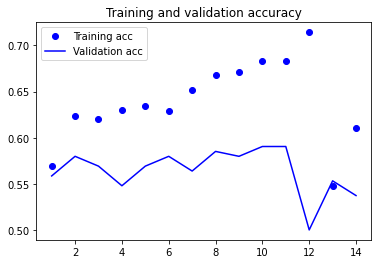

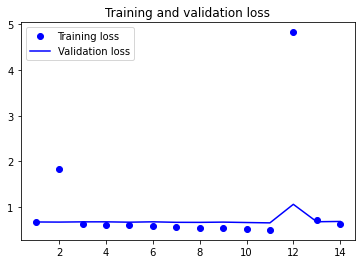

54/54 [==============================] - 1s 15ms/step - loss: 0.8658 - accuracy: 0.1822 - matthews_correlation: -8.8429e-04

-0.0008842930546961725
Epoch 1/100
44/44 [==============================] - 6s 112ms/step - loss: 0.6742 - accuracy: 0.5953 - matthews_correlation: 0.1252 - val_loss: 0.6782 - val_accuracy: 0.5426 - val_matthews_correlation: 0.0135

Epoch 00001: val_matthews_correlation improved from -inf to 0.01353, saving model to /saved_models/model_3.h5
Epoch 2/100
44/44 [==============================] - 5s 107ms/step - loss: 0.6421 - accuracy: 0.6184 - matthews_correlation: 0.2861 - val_loss: 0.6735 - val_accuracy: 0.5691 - val_matthews_correlation: 0.0243

Epoch 00002: val_matthews_correlation improved from 0.01353 to 0.02425, saving model to /saved_models/model_3.h5
Epoch 3/100
44/44 [==============================] - 5s 105ms/step - loss: 0.6720 - accuracy: 0.6409 - matthews_correlation: 0.3144 - val_loss: 1.7648 - val_accuracy: 0.5426 - val_matthews_correlation: -0.0099

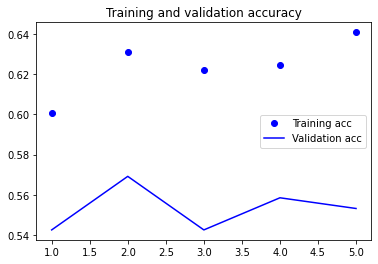

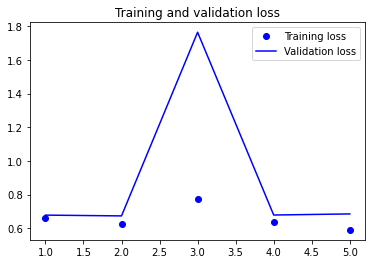

54/54 [==============================] - 1s 15ms/step - loss: 0.6480 - accuracy: 0.2177 - matthews_correlation: -0.0013

-0.0013207586016505957
Epoch 1/100
44/44 [==============================] - 6s 111ms/step - loss: 0.7380 - accuracy: 0.5838 - matthews_correlation: 0.2285 - val_loss: 0.6891 - val_accuracy: 0.5372 - val_matthews_correlation: -0.0084

Epoch 00001: val_matthews_correlation improved from -inf to -0.00842, saving model to /saved_models/model_4.h5
Epoch 2/100
44/44 [==============================] - 5s 105ms/step - loss: 0.6669 - accuracy: 0.6235 - matthews_correlation: 0.2839 - val_loss: 0.6977 - val_accuracy: 0.5479 - val_matthews_correlation: -0.0061

Epoch 00002: val_matthews_correlation improved from -0.00842 to -0.00610, saving model to /saved_models/model_4.h5
Epoch 3/100
44/44 [==============================] - 5s 103ms/step - loss: 420.3462 - accuracy: 0.6136 - matthews_correlation: 0.3324 - val_loss: 0.7077 - val_accuracy: 0.5053 - val_matthews_correlation: 0.00

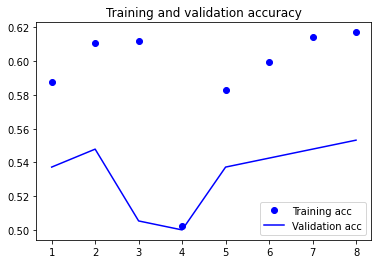

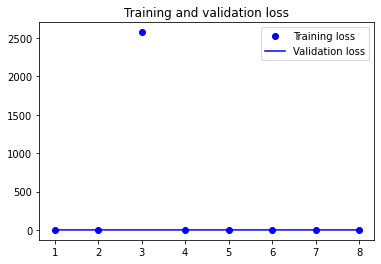

54/54 [==============================] - 1s 15ms/step - loss: 0.8527 - accuracy: 0.0221 - matthews_correlation: -0.0028

-0.002751187887042761
Epoch 1/100
44/44 [==============================] - 6s 110ms/step - loss: 3919.5765 - accuracy: 0.5684 - matthews_correlation: 0.1844 - val_loss: 0.6814 - val_accuracy: 0.5585 - val_matthews_correlation: 0.0133

Epoch 00001: val_matthews_correlation improved from -inf to 0.01329, saving model to /saved_models/model_5.h5
Epoch 2/100
44/44 [==============================] - 5s 105ms/step - loss: 0.6638 - accuracy: 0.6036 - matthews_correlation: 0.2417 - val_loss: 0.6659 - val_accuracy: 0.5479 - val_matthews_correlation: 0.0190

Epoch 00002: val_matthews_correlation improved from 0.01329 to 0.01902, saving model to /saved_models/model_5.h5
Epoch 3/100
44/44 [==============================] - 5s 104ms/step - loss: 0.6397 - accuracy: 0.5887 - matthews_correlation: 0.2314 - val_loss: 0.6666 - val_accuracy: 0.5585 - val_matthews_correlation: 0.0476

E

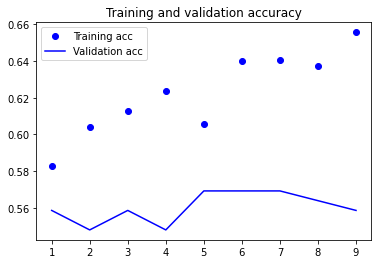

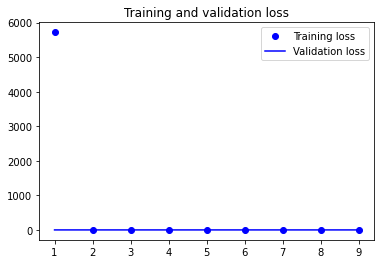

54/54 [==============================] - 1s 16ms/step - loss: 0.6103 - accuracy: 0.9505 - matthews_correlation: -0.0016

-0.0015524299815297127


In [ ]:
best_40 = val_down_data(down_data_40,dataset_val_40,dataset_testing_40,max_words=40)

In [ ]:
print('Index do melhor datset de treino: %d' %best_40)

Index do melhor datset de treino: 0


In [ ]:
X_train_40, Y_train_40, Train_matrix_40, vocab_40, train_token_40 = prepare_full_dataset(down_data_40[best_40],max_len=40)

In [ ]:
X_val_40 , Y_val_40, Val_matrix_40, Y_vocab_40, useless_40 = prepare_full_dataset(dataset_val_40,token_obj=train_token_40,max_len=40)

In [ ]:
X_test_40 , Y_test_40 , test_matrix_40, test_vocab_40, useless_2_40 = prepare_full_dataset(dataset_testing_40, token_obj=train_token_40,max_len=40)

In [ ]:
class MYHyperModel_dep(HyperModel):
    def __init__(self, vocab, matrix,words):
          """
          Args:
              vocab ([int]): [vocabulary size of Embedding]
              matrix ([type]): [word vector matrix for training data, to be used in Embedding]
              words ([int]): [max number of words for input]
          """        
          self.input_shape = vocab
          self.train_matrix = matrix
          self.input_length = words
            
    def build(self,hp):
          """[Creates model to be used in hyperparameter tunning]

          Args:
              hp ([type]): [hyperparameter class]

          Returns:
              []: [Kerastuner model to be optimized]
          """
          model = tf.keras.Sequential()
          model.add(Embedding(self.input_shape, 100, input_length=self.input_length , weights = [self.train_matrix], trainable = False))
          model.add(LSTM(units=hp.Int('units_lstm_1_' , min_value=10, max_value=600, step=20), activation=hp.Choice('a_lstm_1', values =['relu','tanh','elu','selu','swish']),return_sequences=False))
          for i in range(hp.Int('num_layers_Dense_1_',1, 2)):
            model.add(Dense(units=hp.Int('units_dense_1_' + str(i), min_value=10, max_value=400, step=20), 
                            activation=hp.Choice('a_dense_1'+str(i), values =['relu','tanh','elu','selu','swish'])))
                  
          model.add(Dense(1, activation='sigmoid'))
          model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',
                              values=[1e-2, 1e-3, 1e-4])),
                      loss = 'binary_crossentropy', metrics=['accuracy',matthews_correlation])
          
          return model


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/model_optim/model.h5', 
                                                        monitor='val_matthews_correlation', 
                                                        verbose=0, 
                                                        save_best_only=True, mode='max')

In [ ]:
with tf.device('/device:GPU:0'):
    hypermodel_dep_40 = MYHyperModel_dep(vocab_40,Train_matrix_40,words=40)
    tuner_40 = kt.BayesianOptimization(hypermodel_dep_40,
                          objective=kt.Objective("val_matthews_correlation", direction="max"),
                          max_trials=25,
                          num_initial_points=2,
                          directory='/content/optim_lstm_40_wrd_14',
                          project_name='optim_1', seed = 666)
    tuner_40.search_space_summary()
    es = tf.keras.callbacks.EarlyStopping(patience=5)
    tuner_40.search(X_train_40, Y_train_40, epochs=200, batch_size=50, 
              validation_data=(X_val_40, Y_val_40), 
              verbose=0, callbacks=[es, checkpoint])

Search space summary
Default search space size: 6
units_lstm_1_ (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 600, 'step': 20, 'sampling': None}
a_lstm_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu', 'swish'], 'ordered': False}
num_layers_Dense_1_ (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
units_dense_1_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 400, 'step': 20, 'sampling': None}
a_dense_10 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu', 'swish'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps_dep_40 = tuner_40.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
model_dep_lstm_40 = tuner_40.hypermodel.build(best_hps_dep_40)
model_dep_lstm_40.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           436600    
_________________________________________________________________
lstm (LSTM)                  (None, 590)               1630760   
_________________________________________________________________
dense (Dense)                (None, 390)               230490    
_________________________________________________________________
dense_1 (Dense)              (None, 390)               152490    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 391       
Total params: 2,450,731
Trainable params: 2,014,131
Non-trainable params: 436,600
_________________________________________________________________


In [ ]:
filepath= '/content/model_40.h5'
mc_d = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True,monitor='val_matthews_correlation',mode = 'max')
es_d = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)

history_d_40 = model_dep_lstm_40.fit(X_train_40, Y_train_40, epochs=200, batch_size=50, 
                    validation_data=(X_val_40, Y_val_40), 
                    callbacks=[mc_d, es_d])

Epoch 1/200
28/28 [==============================] - 1s 35ms/step - loss: 0.0078 - accuracy: 0.9986 - matthews_correlation: 0.9972 - val_loss: 0.9699 - val_accuracy: 0.8404 - val_matthews_correlation: 0.4021
Epoch 2/200
28/28 [==============================] - 1s 31ms/step - loss: 0.0072 - accuracy: 0.9986 - matthews_correlation: 0.9971 - val_loss: 1.0429 - val_accuracy: 0.8670 - val_matthews_correlation: 0.4332
Epoch 3/200
28/28 [==============================] - 1s 33ms/step - loss: 0.0078 - accuracy: 0.9986 - matthews_correlation: 0.9972 - val_loss: 1.0329 - val_accuracy: 0.8670 - val_matthews_correlation: 0.4332
Epoch 4/200
28/28 [==============================] - 1s 32ms/step - loss: 0.0088 - accuracy: 0.9971 - matthews_correlation: 0.9942 - val_loss: 0.9124 - val_accuracy: 0.8564 - val_matthews_correlation: 0.4108
Epoch 5/200
28/28 [==============================] - 1s 32ms/step - loss: 0.0201 - accuracy: 0.9950 - matthews_correlation: 0.9901 - val_loss: 1.0664 - val_accuracy: 0.

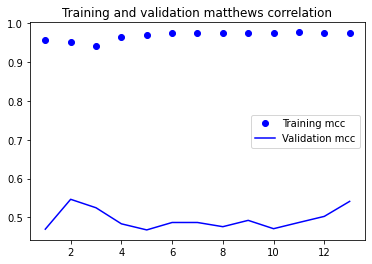

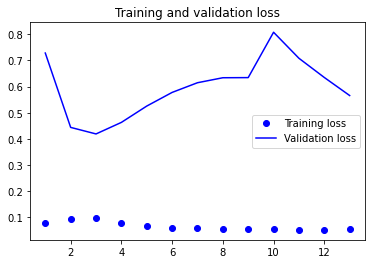

In [ ]:
mcc_40 = history_d_40.history['matthews_correlation']
val_mcc_40 = history_d_40.history['val_matthews_correlation']
loss_40 = history_d_40.history['loss']
val_loss_40 = history_d_40.history['val_loss']
epochs_40 = range(1, len(mcc_40) + 1)
plt.plot(epochs_40, mcc_40, 'bo', label='Training mcc')
plt.plot(epochs_40, val_mcc_40, 'b', label='Validation mcc')
plt.title('Training and validation matthews correlation')
plt.legend()
plt.figure()
plt.plot(epochs_40, loss_40, 'bo', label='Training loss')
plt.plot(epochs_40, val_loss_40, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model_dep_lstm_40.load_weights(filepath)
model_dep_lstm_40.evaluate(X_test_40,Y_test_40)
Y_Predicted_40 = model_dep_lstm_40.predict_classes(X_test_40)

54/54 [==============================] - 0s 9ms/step - loss: 0.3763 - accuracy: 0.9040 - matthews_correlation: 0.0135


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
get_metrics(Y_test_40,Y_Predicted_40)

------------------------------Metrics for model------------------------------
Confusion Matrix:
[[  25   13]
 [ 152 1528]]
-----------------------------------------------------------------------------
Accuracy: 0.903958
-----------------------------------------------------------------------------
Recall: 0.909524
-----------------------------------------------------------------------------
Matthews Correlation Coeficient: 0.274512
-----------------------------------------------------------------------------
F1-Score: 0.948774


# Testing with decreased input words
## 20 words
## Both titles and contents


In [ ]:
reals_20 = pd.concat([treated_reals_05,treated_reals_07],axis = 0)
fakes_20 = pd.concat([treated_fakes_05,treated_fakes_07],axis = 0)

In [ ]:
down_data_20 = downsample(reals_20,fakes_20,multiple=True)

In [ ]:
dataset_val_20 = downsample(treated_reals_09,treated_fakes_09)

In [ ]:
dataset_testing_20 = pd.concat([treated_reals_11,treated_fakes_11])

Epoch 1/100
44/44 [==============================] - 6s 74ms/step - loss: 0.6676 - accuracy: 0.5335 - matthews_correlation: 0.1187 - val_loss: 0.5595 - val_accuracy: 0.6968 - val_matthews_correlation: 0.1467

Epoch 00001: val_matthews_correlation improved from -inf to 0.14670, saving model to /saved_models/model_0.h5
Epoch 2/100
44/44 [==============================] - 3s 66ms/step - loss: 0.4797 - accuracy: 0.8068 - matthews_correlation: 0.6309 - val_loss: 0.5547 - val_accuracy: 0.7606 - val_matthews_correlation: 0.2014

Epoch 00002: val_matthews_correlation improved from 0.14670 to 0.20143, saving model to /saved_models/model_0.h5
Epoch 3/100
44/44 [==============================] - 3s 61ms/step - loss: 0.4551 - accuracy: 0.7899 - matthews_correlation: 0.6021 - val_loss: 0.4468 - val_accuracy: 0.7872 - val_matthews_correlation: 0.2227

Epoch 00003: val_matthews_correlation improved from 0.20143 to 0.22273, saving model to /saved_models/model_0.h5
Epoch 4/100
44/44 [==================

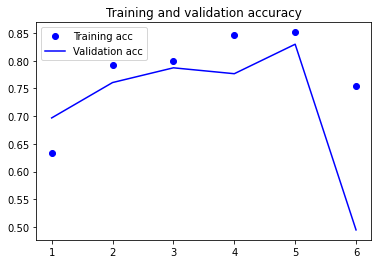

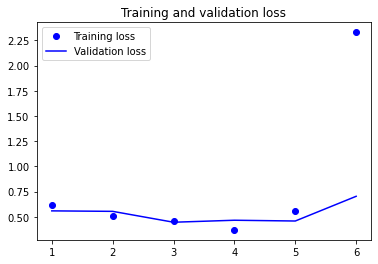

54/54 [==============================] - 0s 8ms/step - loss: 0.3057 - accuracy: 0.8976 - matthews_correlation: 0.0023

0.002278223168104887
Epoch 1/100
44/44 [==============================] - 5s 72ms/step - loss: 0.6602 - accuracy: 0.5929 - matthews_correlation: 0.2345 - val_loss: 0.6131 - val_accuracy: 0.7181 - val_matthews_correlation: 0.2113

Epoch 00001: val_matthews_correlation improved from -inf to 0.21127, saving model to /saved_models/model_1.h5
Epoch 2/100
44/44 [==============================] - 3s 60ms/step - loss: 0.4974 - accuracy: 0.7690 - matthews_correlation: 0.5496 - val_loss: 0.4770 - val_accuracy: 0.7713 - val_matthews_correlation: 0.2328

Epoch 00002: val_matthews_correlation improved from 0.21127 to 0.23282, saving model to /saved_models/model_1.h5
Epoch 3/100
44/44 [==============================] - 3s 57ms/step - loss: 0.3971 - accuracy: 0.8377 - matthews_correlation: 0.6806 - val_loss: 0.5071 - val_accuracy: 0.7660 - val_matthews_correlation: 0.1959

Epoch 0000

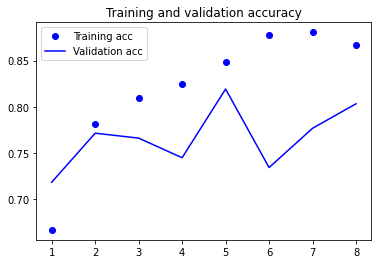

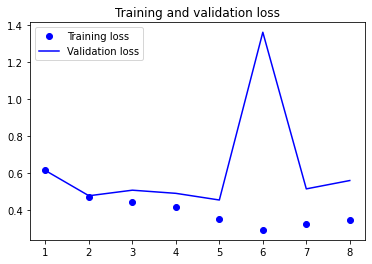

54/54 [==============================] - 0s 9ms/step - loss: 0.4910 - accuracy: 0.8719 - matthews_correlation: 5.1037e-04

0.0005103736184537411
Epoch 1/100
44/44 [==============================] - 4s 69ms/step - loss: 0.6711 - accuracy: 0.5224 - matthews_correlation: 0.0780 - val_loss: 0.6224 - val_accuracy: 0.6862 - val_matthews_correlation: 0.1234

Epoch 00001: val_matthews_correlation improved from -inf to 0.12338, saving model to /saved_models/model_2.h5
Epoch 2/100
44/44 [==============================] - 3s 60ms/step - loss: 0.5237 - accuracy: 0.7594 - matthews_correlation: 0.5504 - val_loss: 0.5586 - val_accuracy: 0.7660 - val_matthews_correlation: 0.1916

Epoch 00002: val_matthews_correlation improved from 0.12338 to 0.19157, saving model to /saved_models/model_2.h5
Epoch 3/100
44/44 [==============================] - 3s 57ms/step - loss: 0.4416 - accuracy: 0.8115 - matthews_correlation: 0.6309 - val_loss: 0.5339 - val_accuracy: 0.7872 - val_matthews_correlation: 0.2281

Epoch

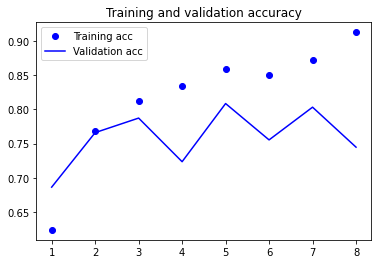

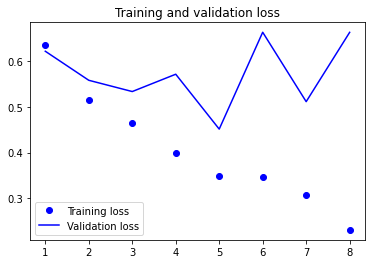

54/54 [==============================] - 0s 9ms/step - loss: 0.2732 - accuracy: 0.9016 - matthews_correlation: 0.0026

0.0025791057851165533
Epoch 1/100
44/44 [==============================] - 4s 70ms/step - loss: 0.6860 - accuracy: 0.4922 - matthews_correlation: 0.0222 - val_loss: 0.6816 - val_accuracy: 0.5426 - val_matthews_correlation: 0.0043

Epoch 00001: val_matthews_correlation improved from -inf to 0.00429, saving model to /saved_models/model_3.h5
Epoch 2/100
44/44 [==============================] - 3s 62ms/step - loss: 0.6491 - accuracy: 0.6087 - matthews_correlation: 0.2774 - val_loss: 0.5960 - val_accuracy: 0.7074 - val_matthews_correlation: 0.1255

Epoch 00002: val_matthews_correlation improved from 0.00429 to 0.12548, saving model to /saved_models/model_3.h5
Epoch 3/100
44/44 [==============================] - 3s 67ms/step - loss: 0.5076 - accuracy: 0.7694 - matthews_correlation: 0.5569 - val_loss: 0.5417 - val_accuracy: 0.7819 - val_matthews_correlation: 0.2109

Epoch 000

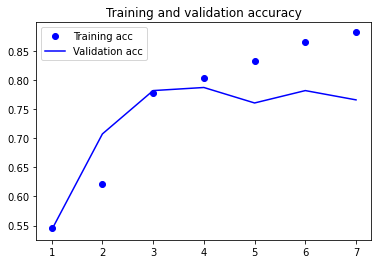

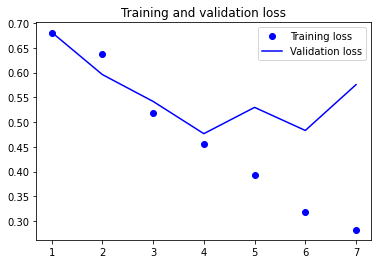

54/54 [==============================] - 0s 9ms/step - loss: 0.4471 - accuracy: 0.8446 - matthews_correlation: 0.0044

0.004399145487695932
Epoch 1/100
44/44 [==============================] - 4s 70ms/step - loss: 0.6863 - accuracy: 0.5292 - matthews_correlation: 0.0953 - val_loss: 0.6630 - val_accuracy: 0.6755 - val_matthews_correlation: 0.1994

Epoch 00001: val_matthews_correlation improved from -inf to 0.19936, saving model to /saved_models/model_4.h5
Epoch 2/100
44/44 [==============================] - 3s 64ms/step - loss: 0.5772 - accuracy: 0.7523 - matthews_correlation: 0.5148 - val_loss: 0.6591 - val_accuracy: 0.5691 - val_matthews_correlation: 0.0981

Epoch 00002: val_matthews_correlation did not improve from 0.19936
Epoch 3/100
44/44 [==============================] - 3s 59ms/step - loss: 0.5734 - accuracy: 0.6918 - matthews_correlation: 0.4405 - val_loss: 0.4256 - val_accuracy: 0.7979 - val_matthews_correlation: 0.2449

Epoch 00003: val_matthews_correlation improved from 0.19

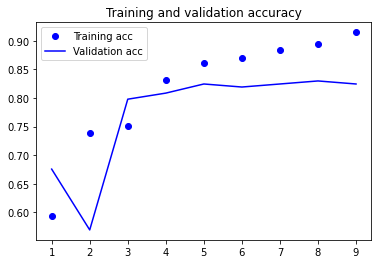

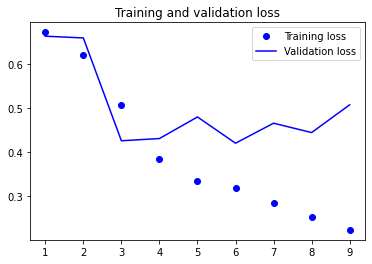

54/54 [==============================] - 0s 9ms/step - loss: 0.4758 - accuracy: 0.8428 - matthews_correlation: -3.5133e-04

-0.00035133404890075326
Epoch 1/100
44/44 [==============================] - 5s 78ms/step - loss: 0.6714 - accuracy: 0.5492 - matthews_correlation: 0.1131 - val_loss: 0.5540 - val_accuracy: 0.7394 - val_matthews_correlation: 0.2004

Epoch 00001: val_matthews_correlation improved from -inf to 0.20042, saving model to /saved_models/model_5.h5
Epoch 2/100
44/44 [==============================] - 3s 65ms/step - loss: 0.4748 - accuracy: 0.7832 - matthews_correlation: 0.5863 - val_loss: 0.4962 - val_accuracy: 0.7660 - val_matthews_correlation: 0.2177

Epoch 00002: val_matthews_correlation improved from 0.20042 to 0.21769, saving model to /saved_models/model_5.h5
Epoch 3/100
44/44 [==============================] - 3s 69ms/step - loss: 0.3866 - accuracy: 0.8309 - matthews_correlation: 0.6546 - val_loss: 0.4844 - val_accuracy: 0.7713 - val_matthews_correlation: 0.2547

Ep

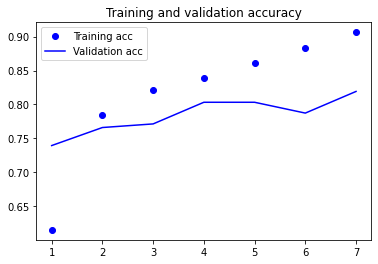

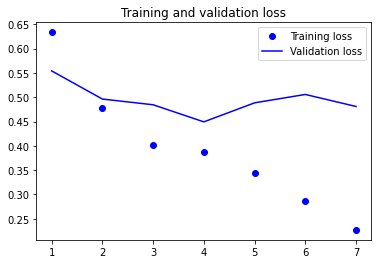

54/54 [==============================] - 1s 9ms/step - loss: 0.3938 - accuracy: 0.8527 - matthews_correlation: 0.0015

0.001502028200775385


In [ ]:
best_20 = val_down_data(down_data_20,dataset_val_20,dataset_testing_20,max_words=20)

In [ ]:
print('Index do melhor datset de treino: %d' %best_20)

Index do melhor datset de treino: 2


In [ ]:
X_train_20, Y_train_20, Train_matrix_20, vocab_20, train_token_20 = prepare_full_dataset(down_data_20[best_20],max_len=20)

In [ ]:
X_val_20 , Y_val_20, Val_matrix_20, Y_vocab_20, useless_20 = prepare_full_dataset(dataset_val_20,token_obj=train_token_20,max_len=20)

In [ ]:
X_test_20 , Y_test_20 , test_matrix_20, test_vocab_20, useless_2_20 = prepare_full_dataset(dataset_testing_20, token_obj=train_token_20,max_len=20)

In [ ]:
class MYHyperModel_dep(HyperModel):
    def __init__(self, vocab, matrix,words):
          """
          Args:
              vocab ([int]): [vocabulary size of Embedding]
              matrix ([type]): [word vector matrix for training data, to be used in Embedding]
              words ([int]): [max number of words for input]
          """        
          self.input_shape = vocab
          self.train_matrix = matrix
          self.input_length = words
            
    def build(self,hp):
          """[Creates model to be used in hyperparameter tunning]

          Args:
              hp ([type]): [hyperparameter class]

          Returns:
              []: [Kerastuner model to be optimized]
          """
          model = tf.keras.Sequential()
          model.add(Embedding(self.input_shape, 100, input_length=self.input_length , weights = [self.train_matrix], trainable = False))
          model.add(LSTM(units=hp.Int('units_lstm_1_' , min_value=10, max_value=750, step=20), activation=hp.Choice('a_lstm_1', values =['relu','tanh','elu','selu','swish']),return_sequences=False))
          for i in range(hp.Int('num_layers_Dense_1_',1, 3)):
            model.add(Dense(units=hp.Int('units_dense_1_' + str(i), min_value=10, max_value=500, step=20), 
                            activation=hp.Choice('a_dense_1'+str(i), values =['relu','tanh','elu','selu','swish'])))
          
          model.add(Dense(1, activation='sigmoid'))
          model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',
                              values=[1e-2, 1e-3, 1e-4])),
                      loss = 'binary_crossentropy', metrics=['accuracy',matthews_correlation])
          
          return model


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/model_optim/model.h5', 
                                                        monitor='val_matthews_correlation', 
                                                        verbose=0, 
                                                        save_best_only=True, mode='max')

In [ ]:
with tf.device('/device:GPU:0'):
    hypermodel_dep_20 = MYHyperModel_dep(vocab_20,Train_matrix_20,words=20)
    tuner_20 = kt.BayesianOptimization(hypermodel_dep_20,
                          objective=kt.Objective("val_matthews_correlation", direction="max"),
                          max_trials=20,
                          num_initial_points=2,
                          directory='/content/optim_lstm_20_wrd_7/',
                          project_name='optim_1', seed = 666)
    tuner_20.search_space_summary()
    es = tf.keras.callbacks.EarlyStopping(patience=5)
    tuner_20.search(X_train_20, Y_train_20, epochs=200, batch_size=20, 
              validation_data=(X_val_20, Y_val_20), 
              verbose=0, callbacks=[es, checkpoint])

Search space summary
Default search space size: 6
units_lstm_1_ (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 750, 'step': 20, 'sampling': None}
a_lstm_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu', 'swish'], 'ordered': False}
num_layers_Dense_1_ (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_dense_1_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 500, 'step': 20, 'sampling': None}
a_dense_10 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu', 'swish'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps_dep_20 = tuner_20.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
model_dep_lstm_20 = tuner_20.hypermodel.build(best_hps_dep_20)
model_dep_lstm_20.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           436200    
_________________________________________________________________
lstm (LSTM)                  (None, 750)               2553000   
_________________________________________________________________
dense (Dense)                (None, 10)                7510      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,996,721
Trainable params: 2,560,521
Non-trainable params: 436,200
_________________________________________________________________


In [ ]:
filepath= '/content/model_20.h5'
mc_d = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True,monitor='val_matthews_correlation',mode = 'max')
es_d = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)

history_d_20 = model_dep_lstm_20.fit(X_train_20, Y_train_20, epochs=200, batch_size=20, 
                    validation_data=(X_val_20, Y_val_20), 
                    callbacks=[mc_d, es_d])

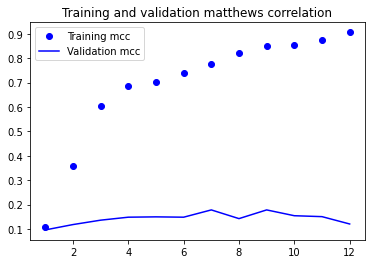

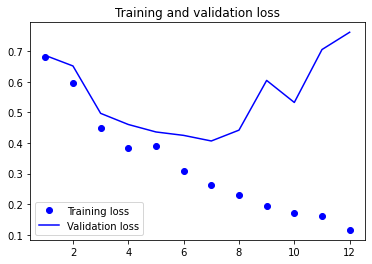

In [ ]:
mcc_20 = history_d_20.history['matthews_correlation']
val_mcc_20 = history_d_20.history['val_matthews_correlation']
loss_20 = history_d_20.history['loss']
val_loss_20 = history_d_20.history['val_loss']
epochs_20 = range(1, len(mcc_20) + 1)
plt.plot(epochs_20, mcc_20, 'bo', label='Training mcc')
plt.plot(epochs_20, val_mcc_20, 'b', label='Validation mcc')
plt.title('Training and validation matthews correlation')
plt.legend()
plt.figure()
plt.plot(epochs_20, loss_20, 'bo', label='Training loss')
plt.plot(epochs_20, val_loss_20, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model_dep_lstm_20.load_weights(filepath)
model_dep_lstm_20.evaluate(X_test_20,Y_test_20)
Y_Predicted_20 = model_dep_lstm_20.predict_classes(X_test_20)

54/54 [==============================] - 0s 7ms/step - loss: 0.4485 - accuracy: 0.8108 - matthews_correlation: 5.9763e-04


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
get_metrics(Y_test_20,Y_Predicted_20)

------------------------------Metrics for model------------------------------
Confusion Matrix:
[[  31    7]
 [ 318 1362]]
-----------------------------------------------------------------------------
Accuracy: 0.810827
-----------------------------------------------------------------------------
Recall: 0.810714
-----------------------------------------------------------------------------
Matthews Correlation Coeficient: 0.229011
-----------------------------------------------------------------------------
F1-Score: 0.893408


#Testing different inputs (contents)
## 30 words
## Only contents


In [ ]:
reals_con30 = pd.concat([treated_reals_05,treated_reals_07],axis = 0)
fakes_con30 = pd.concat([treated_fakes_05,treated_fakes_07],axis = 0)

In [ ]:
down_data_con30 = downsample(reals_con30,fakes_con30,multiple=True)

In [ ]:
dataset_val_con30 = downsample(treated_reals_09,treated_fakes_09)

In [ ]:
dataset_testing_con30 = pd.concat([treated_reals_11,treated_fakes_11])

Epoch 1/100
22/22 [==============================] - 3s 96ms/step - loss: 0.6612 - accuracy: 0.6102 - matthews_correlation: 0.2443 - val_loss: 0.6411 - val_accuracy: 0.6702 - val_matthews_correlation: 0.1170

Epoch 00001: val_matthews_correlation improved from -inf to 0.11699, saving model to /saved_models/model_0.h5
Epoch 2/100
22/22 [==============================] - 2s 86ms/step - loss: 0.5495 - accuracy: 0.7394 - matthews_correlation: 0.5284 - val_loss: 0.4870 - val_accuracy: 0.7553 - val_matthews_correlation: 0.1446

Epoch 00002: val_matthews_correlation improved from 0.11699 to 0.14464, saving model to /saved_models/model_0.h5
Epoch 3/100
22/22 [==============================] - 2s 84ms/step - loss: 526.1829 - accuracy: 0.7993 - matthews_correlation: 0.6019 - val_loss: 0.5877 - val_accuracy: 0.7340 - val_matthews_correlation: 0.1235

Epoch 00003: val_matthews_correlation did not improve from 0.14464
Epoch 4/100
22/22 [==============================] - 2s 86ms/step - loss: 0.5326 

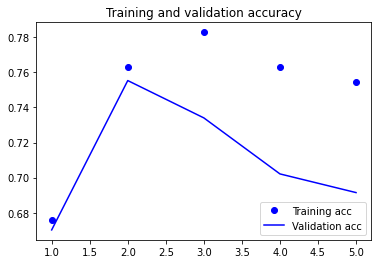

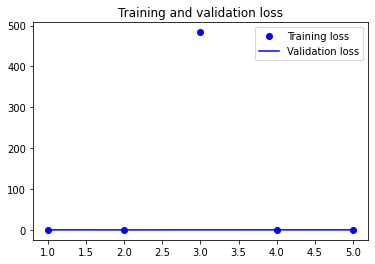

27/27 [==============================] - 0s 12ms/step - loss: 0.6734 - accuracy: 0.4331 - matthews_correlation: 0.0106

0.010642802342772484
Epoch 1/100
22/22 [==============================] - 3s 95ms/step - loss: 0.6667 - accuracy: 0.6013 - matthews_correlation: 0.2470 - val_loss: 0.5647 - val_accuracy: 0.7447 - val_matthews_correlation: 0.1242

Epoch 00001: val_matthews_correlation improved from -inf to 0.12418, saving model to /saved_models/model_1.h5
Epoch 2/100
22/22 [==============================] - 2s 85ms/step - loss: 0.5291 - accuracy: 0.7554 - matthews_correlation: 0.5184 - val_loss: 0.5269 - val_accuracy: 0.7234 - val_matthews_correlation: 0.1044

Epoch 00002: val_matthews_correlation did not improve from 0.12418
Epoch 3/100
22/22 [==============================] - 2s 82ms/step - loss: 0.5057 - accuracy: 0.7476 - matthews_correlation: 0.5294 - val_loss: 0.4268 - val_accuracy: 0.8404 - val_matthews_correlation: 0.1920

Epoch 00003: val_matthews_correlation improved from 0.1

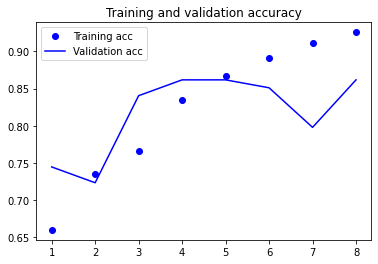

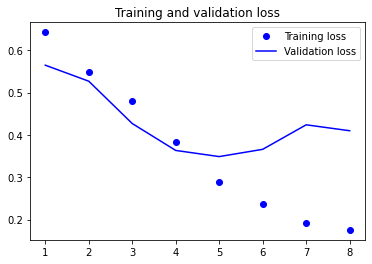

27/27 [==============================] - 0s 12ms/step - loss: 0.0784 - accuracy: 0.9779 - matthews_correlation: 0.0232

0.023158589377999306
Epoch 1/100
22/22 [==============================] - 3s 98ms/step - loss: 0.6448 - accuracy: 0.6364 - matthews_correlation: 0.2758 - val_loss: 0.6214 - val_accuracy: 0.6809 - val_matthews_correlation: 0.1041

Epoch 00001: val_matthews_correlation improved from -inf to 0.10414, saving model to /saved_models/model_2.h5
Epoch 2/100
22/22 [==============================] - 2s 81ms/step - loss: 0.4973 - accuracy: 0.8071 - matthews_correlation: 0.6251 - val_loss: 0.3266 - val_accuracy: 0.8830 - val_matthews_correlation: 0.2105

Epoch 00002: val_matthews_correlation improved from 0.10414 to 0.21046, saving model to /saved_models/model_2.h5
Epoch 3/100
22/22 [==============================] - 2s 83ms/step - loss: 56.4711 - accuracy: 0.8468 - matthews_correlation: 0.7056 - val_loss: 0.6092 - val_accuracy: 0.7021 - val_matthews_correlation: 0.1024

Epoch 00

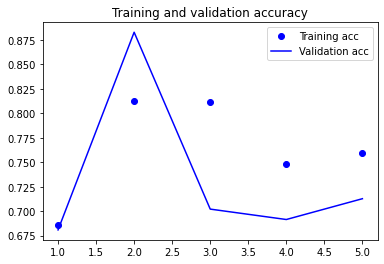

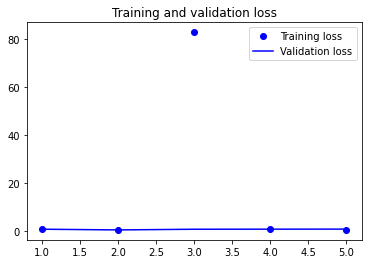

27/27 [==============================] - 0s 12ms/step - loss: 0.3017 - accuracy: 0.9430 - matthews_correlation: 0.0305

0.030509425327181816
Epoch 1/100
22/22 [==============================] - 4s 110ms/step - loss: 91.5340 - accuracy: 0.6201 - matthews_correlation: 0.2295 - val_loss: 0.6154 - val_accuracy: 0.6809 - val_matthews_correlation: 0.0591

Epoch 00001: val_matthews_correlation improved from -inf to 0.05911, saving model to /saved_models/model_3.h5
Epoch 2/100
22/22 [==============================] - 2s 86ms/step - loss: 0.6335 - accuracy: 0.6844 - matthews_correlation: 0.4489 - val_loss: 0.6247 - val_accuracy: 0.6809 - val_matthews_correlation: 0.0591

Epoch 00002: val_matthews_correlation did not improve from 0.05911
Epoch 3/100
22/22 [==============================] - 2s 80ms/step - loss: 0.5853 - accuracy: 0.7061 - matthews_correlation: 0.4394 - val_loss: 0.6252 - val_accuracy: 0.6915 - val_matthews_correlation: 0.0810

Epoch 00003: val_matthews_correlation improved from 0

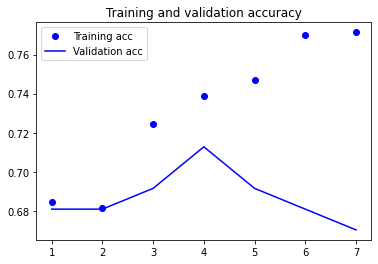

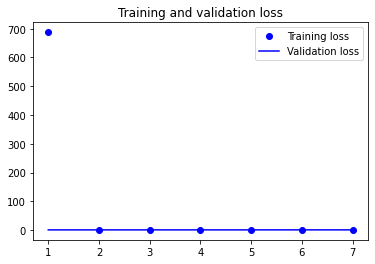

27/27 [==============================] - 0s 12ms/step - loss: 0.7804 - accuracy: 0.3912 - matthews_correlation: 0.0063

0.006347320042550564
Epoch 1/100
22/22 [==============================] - 3s 99ms/step - loss: 0.6502 - accuracy: 0.6147 - matthews_correlation: 0.2194 - val_loss: 0.5884 - val_accuracy: 0.7340 - val_matthews_correlation: 0.1026

Epoch 00001: val_matthews_correlation improved from -inf to 0.10257, saving model to /saved_models/model_4.h5
Epoch 2/100
22/22 [==============================] - 2s 85ms/step - loss: 0.5915 - accuracy: 0.7707 - matthews_correlation: 0.5632 - val_loss: 0.6627 - val_accuracy: 0.7021 - val_matthews_correlation: 0.0810

Epoch 00002: val_matthews_correlation did not improve from 0.10257
Epoch 3/100
22/22 [==============================] - 2s 84ms/step - loss: 0.5442 - accuracy: 0.7857 - matthews_correlation: 0.6034 - val_loss: 0.5841 - val_accuracy: 0.6702 - val_matthews_correlation: 0.0810

Epoch 00003: val_matthews_correlation did not improve f

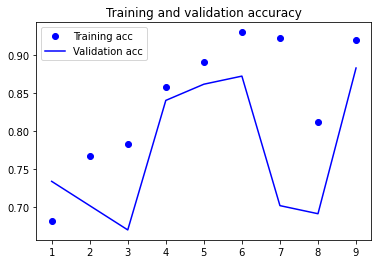

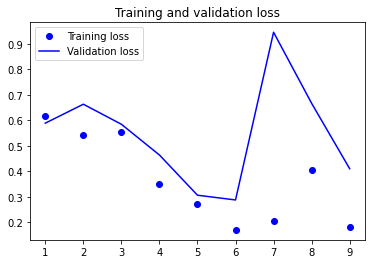

27/27 [==============================] - 0s 12ms/step - loss: 0.2457 - accuracy: 0.9104 - matthews_correlation: 0.0238

0.02380312979221344
Epoch 1/100
22/22 [==============================] - 4s 99ms/step - loss: 0.6549 - accuracy: 0.6780 - matthews_correlation: 0.3567 - val_loss: 0.5717 - val_accuracy: 0.6915 - val_matthews_correlation: 0.0591

Epoch 00001: val_matthews_correlation improved from -inf to 0.05911, saving model to /saved_models/model_5.h5
Epoch 2/100
22/22 [==============================] - 2s 85ms/step - loss: 0.4491 - accuracy: 0.8073 - matthews_correlation: 0.6328 - val_loss: 0.3526 - val_accuracy: 0.8404 - val_matthews_correlation: 0.2266

Epoch 00002: val_matthews_correlation improved from 0.05911 to 0.22661, saving model to /saved_models/model_5.h5
Epoch 3/100
22/22 [==============================] - 2s 87ms/step - loss: 0.4010 - accuracy: 0.8103 - matthews_correlation: 0.6429 - val_loss: 0.4525 - val_accuracy: 0.8723 - val_matthews_correlation: 0.2105

Epoch 0000

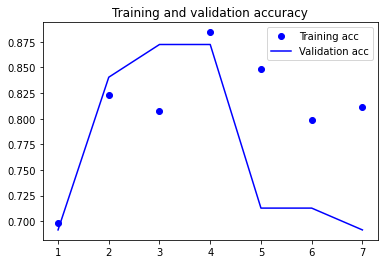

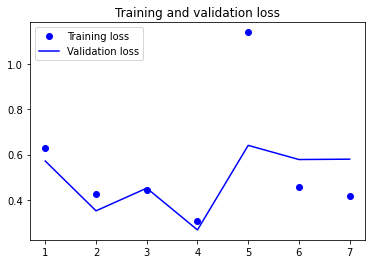

27/27 [==============================] - 0s 12ms/step - loss: 0.1391 - accuracy: 0.9721 - matthews_correlation: 0.0148

0.01477822009474039


In [ ]:
best_con30 = val_down_data(down_data_con30,dataset_val_con30,dataset_testing_con30,max_words=30,mod='c')

In [ ]:
print('Index do melhor datset de treino: %d' %best_con30)

Index do melhor datset de treino: 5


In [ ]:
X_train_con30, Y_train_con30, Train_matrix_con30, vocab_con30, train_token_con30 = prepare_full_dataset(down_data_con30[best_con30],max_len=30,mode='c')

In [ ]:
X_val_con30 , Y_val_con30, Val_matrix_con30, Y_vocab_con30, useless_con30 = prepare_full_dataset(dataset_val_con30,token_obj=train_token_con30,max_len=30,mode='c')

In [ ]:
X_test_con30 , Y_test_con30 , test_matrix_con30, test_vocab_con30, useless_2_con30 = prepare_full_dataset(dataset_testing_con30, token_obj=train_token_con30,max_len=30,mode='c')

In [ ]:
class MYHyperModel_dep(HyperModel):
    def __init__(self, vocab, matrix,words):
          """
          Args:
              vocab ([int]): [vocabulary size of Embedding]
              matrix ([type]): [word vector matrix for training data, to be used in Embedding]
              words ([int]): [max number of words for input]
          """        
          self.input_shape = vocab
          self.train_matrix = matrix
          self.input_length = words
            
    def build(self,hp):
          """[Creates model to be used in hyperparameter tunning]

          Args:
              hp ([type]): [hyperparameter class]

          Returns:
              []: [Kerastuner model to be optimized]
          """
          model = tf.keras.Sequential()
          model.add(Embedding(self.input_shape, 100, input_length=self.input_length , weights = [self.train_matrix], trainable = False))
          model.add(LSTM(units=hp.Int('units_lstm_1_' , min_value=10, max_value=1100, step=20), activation=hp.Choice('a_lstm_1', values =['relu','tanh','elu','selu','swish']),return_sequences=False))
          for i in range(hp.Int('num_layers_Dense_1_',1, 2)):
            model.add(Dense(units=hp.Int('units_dense_1_' + str(i), min_value=10, max_value=1000, step=20), 
                            activation=hp.Choice('a_dense_1'+str(i), values =['relu','tanh','elu','selu','swish'])))
          
          model.add(Dense(1, activation='sigmoid'))
          model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',
                              values=[1e-2, 1e-3, 1e-4])),
                      loss = 'binary_crossentropy', metrics=['accuracy',matthews_correlation])
          
          return model


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/model_optim/model.h5', 
                                                        monitor='val_matthews_correlation', 
                                                        verbose=0, 
                                                        save_best_only=True, mode='max')

In [ ]:
with tf.device('/device:GPU:0'):
    hypermodel_dep_con30 = MYHyperModel_dep(vocab_con30,Train_matrix_con30,words=30)
    tuner_con30 = kt.BayesianOptimization(hypermodel_dep_con30,
                          objective=kt.Objective("val_matthews_correlation", direction="max"),
                          max_trials=25,
                          num_initial_points=2,
                          directory='/content/optim_lstm_con30_wrd_4/',
                          project_name='optim_1', seed = 666)
    tuner_con30.search_space_summary()
    es = tf.keras.callbacks.EarlyStopping(patience=5)
    tuner_con30.search(X_train_con30, Y_train_con30, epochs=200, batch_size=50, 
              validation_data=(X_val_con30, Y_val_con30), 
              verbose=0, callbacks=[es, checkpoint])

Search space summary
Default search space size: 6
units_lstm_1_ (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 1100, 'step': 20, 'sampling': None}
a_lstm_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu', 'swish'], 'ordered': False}
num_layers_Dense_1_ (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
units_dense_1_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 1000, 'step': 20, 'sampling': None}
a_dense_10 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu', 'swish'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps_dep_con30 = tuner_con30.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
model_dep_lstm_con30 = tuner_con30.hypermodel.build(best_hps_dep_con30)
model_dep_lstm_con30.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           390000    
_________________________________________________________________
lstm (LSTM)                  (None, 1090)              5192760   
_________________________________________________________________
dense (Dense)                (None, 10)                10910     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 5,593,681
Trainable params: 5,203,681
Non-trainable params: 390,000
_________________________________________________________________


In [ ]:
filepath= '/content/model_con30.h5'
mc_d = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True,monitor='val_matthews_correlation',mode = 'max')
es_d = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)

history_d_con30 = model_dep_lstm_con30.fit(X_train_con30, Y_train_con30, epochs=200, batch_size=50, 
                    validation_data=(X_val_con30, Y_val_con30), 
                    callbacks=[mc_d, es_d])

Epoch 1/200
14/14 [==============================] - 2s 67ms/step - loss: 0.6797 - accuracy: 0.6489 - matthews_correlation: 0.3341 - val_loss: 0.6486 - val_accuracy: 0.6489 - val_matthews_correlation: 0.0939
Epoch 2/200
14/14 [==============================] - 1s 41ms/step - loss: 0.6552 - accuracy: 0.6536 - matthews_correlation: 0.3160 - val_loss: 0.6480 - val_accuracy: 0.7234 - val_matthews_correlation: 0.1760
Epoch 3/200
14/14 [==============================] - 1s 41ms/step - loss: 0.6381 - accuracy: 0.6814 - matthews_correlation: 0.3826 - val_loss: 0.6288 - val_accuracy: 0.7234 - val_matthews_correlation: 0.1760
Epoch 4/200
14/14 [==============================] - 1s 42ms/step - loss: 0.6112 - accuracy: 0.6806 - matthews_correlation: 0.3728 - val_loss: 0.6028 - val_accuracy: 0.7234 - val_matthews_correlation: 0.1547
Epoch 5/200
14/14 [==============================] - 1s 41ms/step - loss: 0.4998 - accuracy: 0.7943 - matthews_correlation: 0.6091 - val_loss: 0.5606 - val_accuracy: 0.

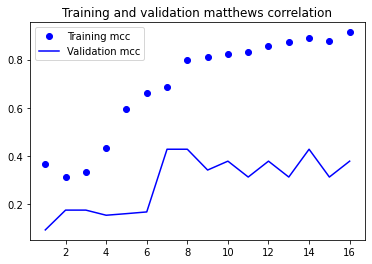

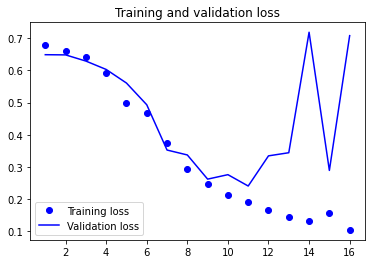

In [ ]:
mcc_con30 = history_d_con30.history['matthews_correlation']
val_mcc_con30 = history_d_con30.history['val_matthews_correlation']
loss_con30 = history_d_con30.history['loss']
val_loss_con30 = history_d_con30.history['val_loss']
epochs_con30 = range(1, len(mcc_con30) + 1)
plt.plot(epochs_con30, mcc_con30, 'bo', label='Training mcc')
plt.plot(epochs_con30, val_mcc_con30, 'b', label='Validation mcc')
plt.title('Training and validation matthews correlation')
plt.legend()
plt.figure()
plt.plot(epochs_con30, loss_con30, 'bo', label='Training loss')
plt.plot(epochs_con30, val_loss_con30, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model_dep_lstm_con30.load_weights(filepath)
model_dep_lstm_con30.evaluate(X_test_con30,Y_test_con30)
Y_Predicted_con30 = model_dep_lstm_con30.predict_classes(X_test_con30)

27/27 [==============================] - 0s 11ms/step - loss: 0.1712 - accuracy: 0.9267 - matthews_correlation: 0.0161


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
get_metrics(Y_test_con30,Y_Predicted_con30)

------------------------------Metrics for model------------------------------
Confusion Matrix:
[[ 17   2]
 [ 61 779]]
-----------------------------------------------------------------------------
Accuracy: 0.926659
-----------------------------------------------------------------------------
Recall: 0.927381
-----------------------------------------------------------------------------
Matthews Correlation Coeficient: 0.420802
-----------------------------------------------------------------------------
F1-Score: 0.961135


#Testing different inputs (Titles)
## 30 words 
## Only titles


In [ ]:
reals_titl30 = pd.concat([treated_reals_05,treated_reals_07],axis = 0)
fakes_titl30 = pd.concat([treated_fakes_05,treated_fakes_07],axis = 0)

In [ ]:
down_data_titl30 = downsample(reals_titl30,fakes_titl30,multiple=True)

In [ ]:
dataset_val_titl30 = downsample(treated_reals_09,treated_fakes_09)

In [ ]:
dataset_testing_titl30 = pd.concat([treated_reals_11,treated_fakes_11])

Epoch 1/100
22/22 [==============================] - 3s 97ms/step - loss: 0.6949 - accuracy: 0.5172 - matthews_correlation: -0.0211 - val_loss: 0.6911 - val_accuracy: 0.5851 - val_matthews_correlation: 0.1183

Epoch 00001: val_matthews_correlation improved from -inf to 0.11835, saving model to /saved_models/model_0.h5
Epoch 2/100
22/22 [==============================] - 2s 81ms/step - loss: 0.8674 - accuracy: 0.5562 - matthews_correlation: 0.1385 - val_loss: 0.6626 - val_accuracy: 0.7872 - val_matthews_correlation: 0.1461

Epoch 00002: val_matthews_correlation improved from 0.11835 to 0.14612, saving model to /saved_models/model_0.h5
Epoch 3/100
22/22 [==============================] - 2s 82ms/step - loss: 0.6879 - accuracy: 0.5451 - matthews_correlation: 0.1085 - val_loss: 0.6912 - val_accuracy: 0.5319 - val_matthews_correlation: 0.0808

Epoch 00003: val_matthews_correlation did not improve from 0.14612
Epoch 4/100
22/22 [==============================] - 2s 82ms/step - loss: 0.6918 -

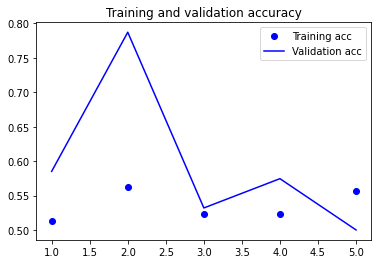

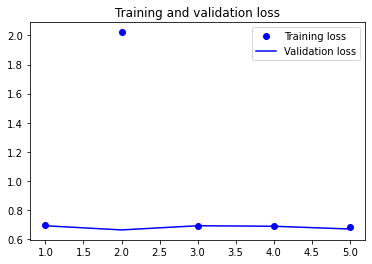

27/27 [==============================] - 0s 12ms/step - loss: 0.6847 - accuracy: 0.8626 - matthews_correlation: 0.0087

0.008732584305107594
Epoch 1/100
22/22 [==============================] - 3s 94ms/step - loss: 0.7648 - accuracy: 0.4875 - matthews_correlation: -0.0288 - val_loss: 0.6920 - val_accuracy: 0.5319 - val_matthews_correlation: 0.0808

Epoch 00001: val_matthews_correlation improved from -inf to 0.08085, saving model to /saved_models/model_1.h5
Epoch 2/100
22/22 [==============================] - 2s 81ms/step - loss: 0.6914 - accuracy: 0.5342 - matthews_correlation: 0.0436 - val_loss: 0.6899 - val_accuracy: 0.5745 - val_matthews_correlation: 0.1183

Epoch 00002: val_matthews_correlation improved from 0.08085 to 0.11835, saving model to /saved_models/model_1.h5
Epoch 3/100
22/22 [==============================] - 2s 83ms/step - loss: 1.5456 - accuracy: 0.6301 - matthews_correlation: 0.2779 - val_loss: 0.6648 - val_accuracy: 0.5957 - val_matthews_correlation: 0.1347

Epoch 00

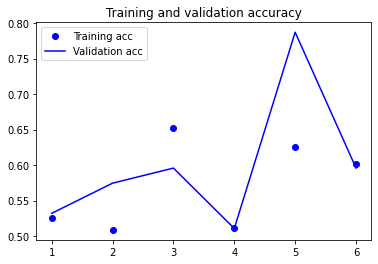

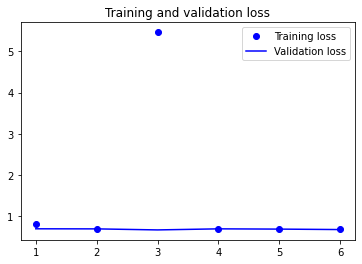

27/27 [==============================] - 0s 12ms/step - loss: 0.6894 - accuracy: 0.9383 - matthews_correlation: 0.0129

0.012915367260575294
Epoch 1/100
22/22 [==============================] - 3s 98ms/step - loss: 0.6905 - accuracy: 0.5233 - matthews_correlation: 0.0136 - val_loss: 0.6809 - val_accuracy: 0.5638 - val_matthews_correlation: 0.1007

Epoch 00001: val_matthews_correlation improved from -inf to 0.10071, saving model to /saved_models/model_2.h5
Epoch 2/100
22/22 [==============================] - 2s 82ms/step - loss: 1.3165 - accuracy: 0.6137 - matthews_correlation: 0.2992 - val_loss: 0.6954 - val_accuracy: 0.5106 - val_matthews_correlation: 0.0562

Epoch 00002: val_matthews_correlation did not improve from 0.10071
Epoch 3/100
22/22 [==============================] - 2s 86ms/step - loss: 0.6978 - accuracy: 0.4943 - matthews_correlation: 0.0671 - val_loss: 0.6883 - val_accuracy: 0.5000 - val_matthews_correlation: 0.0000e+00

Epoch 00003: val_matthews_correlation did not impro

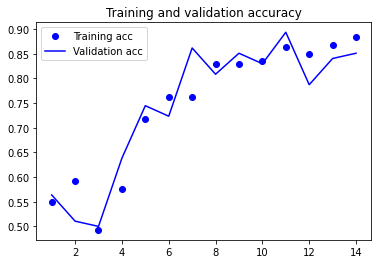

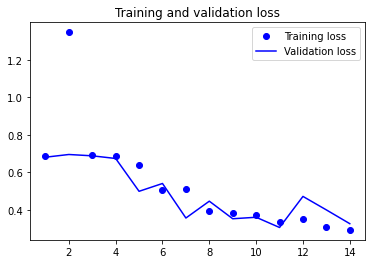

27/27 [==============================] - 0s 12ms/step - loss: 0.4410 - accuracy: 0.8580 - matthews_correlation: 0.0065

0.0064513119868934155
Epoch 1/100
22/22 [==============================] - 3s 96ms/step - loss: 0.6845 - accuracy: 0.5441 - matthews_correlation: 0.1009 - val_loss: 0.6400 - val_accuracy: 0.7766 - val_matthews_correlation: 0.1994

Epoch 00001: val_matthews_correlation improved from -inf to 0.19942, saving model to /saved_models/model_3.h5
Epoch 2/100
22/22 [==============================] - 2s 82ms/step - loss: 0.6108 - accuracy: 0.6884 - matthews_correlation: 0.4186 - val_loss: 0.6730 - val_accuracy: 0.7021 - val_matthews_correlation: 0.1250

Epoch 00002: val_matthews_correlation did not improve from 0.19942
Epoch 3/100
22/22 [==============================] - 2s 82ms/step - loss: 0.6724 - accuracy: 0.5654 - matthews_correlation: 0.1243 - val_loss: 0.6912 - val_accuracy: 0.5213 - val_matthews_correlation: 0.0808

Epoch 00003: val_matthews_correlation did not improve 

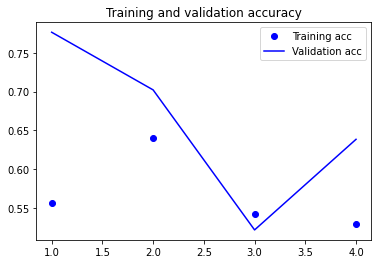

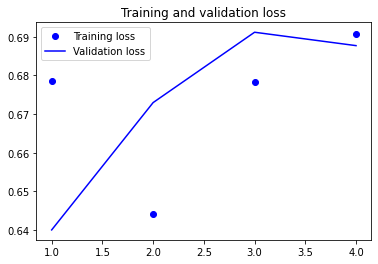

27/27 [==============================] - 0s 12ms/step - loss: 0.5992 - accuracy: 0.9499 - matthews_correlation: 0.0077

0.007699048146605492
Epoch 1/100
22/22 [==============================] - 3s 98ms/step - loss: 0.6880 - accuracy: 0.5256 - matthews_correlation: 0.1032 - val_loss: 0.6863 - val_accuracy: 0.5638 - val_matthews_correlation: 0.1007

Epoch 00001: val_matthews_correlation improved from -inf to 0.10071, saving model to /saved_models/model_4.h5
Epoch 2/100
22/22 [==============================] - 2s 86ms/step - loss: 5.4635 - accuracy: 0.5375 - matthews_correlation: 0.2224 - val_loss: 0.6948 - val_accuracy: 0.5106 - val_matthews_correlation: 0.0562

Epoch 00002: val_matthews_correlation did not improve from 0.10071
Epoch 3/100
22/22 [==============================] - 2s 85ms/step - loss: 0.7031 - accuracy: 0.4837 - matthews_correlation: 0.0354 - val_loss: 0.6882 - val_accuracy: 0.5532 - val_matthews_correlation: 0.1007

Epoch 00003: val_matthews_correlation did not improve f

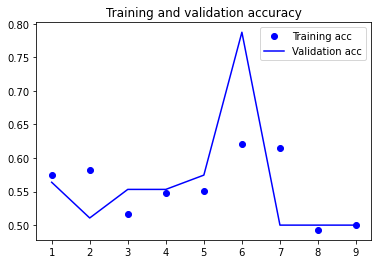

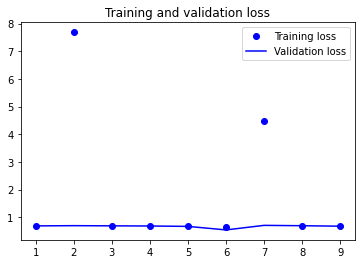

27/27 [==============================] - 0s 12ms/step - loss: 0.5280 - accuracy: 0.9104 - matthews_correlation: 0.0111

0.011133937165141106
Epoch 1/100
22/22 [==============================] - 3s 101ms/step - loss: 0.6891 - accuracy: 0.5049 - matthews_correlation: 0.1058 - val_loss: 0.6878 - val_accuracy: 0.5319 - val_matthews_correlation: 0.0808

Epoch 00001: val_matthews_correlation improved from -inf to 0.08085, saving model to /saved_models/model_5.h5
Epoch 2/100
22/22 [==============================] - 2s 84ms/step - loss: 0.6787 - accuracy: 0.5540 - matthews_correlation: 0.2179 - val_loss: 0.6832 - val_accuracy: 0.5426 - val_matthews_correlation: 0.1007

Epoch 00002: val_matthews_correlation improved from 0.08085 to 0.10071, saving model to /saved_models/model_5.h5
Epoch 3/100
22/22 [==============================] - 2s 86ms/step - loss: 0.6449 - accuracy: 0.6372 - matthews_correlation: 0.2832 - val_loss: 0.6914 - val_accuracy: 0.5957 - val_matthews_correlation: 0.1347

Epoch 00

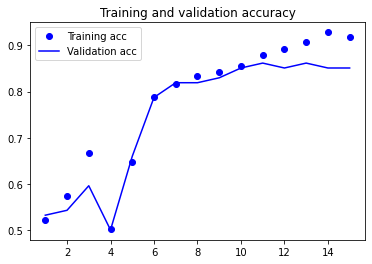

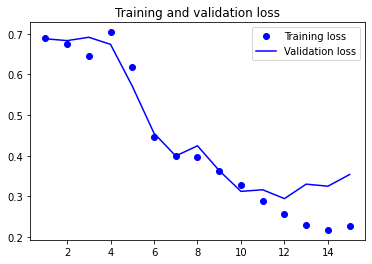

27/27 [==============================] - 0s 12ms/step - loss: 0.3253 - accuracy: 0.8673 - matthews_correlation: 0.0069

0.0069030411541461945


In [ ]:
best_titl30 = val_down_data(down_data_titl30,dataset_val_titl30,dataset_testing_titl30,max_words=30,mod='t')

In [ ]:
print('Index do melhor datset de treino: %d' %best_titl30)

Index do melhor datset de treino: 5


In [ ]:
X_train_titl30, Y_train_titl30, Train_matrix_titl30, vocab_titl30, train_token_titl30 = prepare_full_dataset(down_data_titl30[best_titl30],max_len=30,mode='t')

In [ ]:
X_val_titl30 , Y_val_titl30, Val_matrix_titl30, Y_vocab_titl30, useless_titl30 = prepare_full_dataset(dataset_val_titl30,token_obj=train_token_titl30,max_len=30,mode='t')

In [ ]:
X_test_titl30 , Y_test_titl30 , test_matrix_titl30, test_vocab_titl30, useless_2_titl30 = prepare_full_dataset(dataset_testing_titl30, token_obj=train_token_titl30,max_len=30,mode='t')

In [ ]:
class MYHyperModel_dep(HyperModel):
    def __init__(self, vocab, matrix,words):
          """
          Args:
              vocab ([int]): [vocabulary size of Embedding]
              matrix ([type]): [word vector matrix for training data, to be used in Embedding]
              words ([int]): [max number of words for input]
          """        
          self.input_shape = vocab
          self.train_matrix = matrix
          self.input_length = words
            
    def build(self,hp):
          """[Creates model to be used in hyperparameter tunning]

          Args:
              hp ([type]): [hyperparameter class]

          Returns:
              []: [Kerastuner model to be optimized]
          """
          model = tf.keras.Sequential()
          model.add(Embedding(self.input_shape, 100, input_length=self.input_length , weights = [self.train_matrix], trainable = False))
          model.add(LSTM(units=hp.Int('units_lstm_1_' , min_value=10, max_value=1500, step=20), activation=hp.Choice('a_lstm_1', values =['relu','tanh','elu','selu','swish']),return_sequences=False))
          for i in range(hp.Int('num_layers_Dense_1_',1, 2)):
            model.add(Dense(units=hp.Int('units_dense_1_' + str(i), min_value=10, max_value=1000, step=20), 
                            activation=hp.Choice('a_dense_1'+str(i), values =['relu','tanh','elu','selu','swish'])))
          
          model.add(Dense(1, activation='sigmoid'))
          model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',
                              values=[1e-2, 1e-3, 1e-4])),
                      loss = 'binary_crossentropy', metrics=['accuracy',matthews_correlation])
          
          return model


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/model_optim/model.h5', 
                                                        monitor='val_matthews_correlation', 
                                                        verbose=0, 
                                                        save_best_only=True, mode='max')

In [ ]:
with tf.device('/device:GPU:0'):
    hypermodel_dep_titl30 = MYHyperModel_dep(vocab_titl30,Train_matrix_titl30,words=30)
    tuner_titl30 = kt.BayesianOptimization(hypermodel_dep_titl30,
                          objective=kt.Objective("val_matthews_correlation", direction="max"),
                          max_trials=25,
                          num_initial_points=2,
                          directory='/content/optim_lstm_titl30_wrd_5/',
                          project_name='optim_1', seed = 666)
    tuner_titl30.search_space_summary()
    es = tf.keras.callbacks.EarlyStopping(patience=5)
    tuner_titl30.search(X_train_titl30, Y_train_titl30, epochs=200, batch_size=50, 
              validation_data=(X_val_titl30, Y_val_titl30), 
              verbose=0, callbacks=[es, checkpoint])

Search space summary
Default search space size: 6
units_lstm_1_ (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 1500, 'step': 20, 'sampling': None}
a_lstm_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu', 'swish'], 'ordered': False}
num_layers_Dense_1_ (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
units_dense_1_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 1000, 'step': 20, 'sampling': None}
a_dense_10 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu', 'swish'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps_dep_titl30 = tuner_titl30.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
model_dep_lstm_titl30 = tuner_titl30.hypermodel.build(best_hps_dep_titl30)
model_dep_lstm_titl30.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           186400    
_________________________________________________________________
lstm (LSTM)                  (None, 1490)              9482360   
_________________________________________________________________
dense (Dense)                (None, 990)               1476090   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                9910      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 11,154,771
Trainable params: 10,968,371
Non-trainable params: 186,400
_________________________________________________________________


In [ ]:
filepath= '/content/model_titl30.h5'
mc_d = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True,monitor='val_matthews_correlation',mode = 'max')
es_d = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)

history_d_titl30 = model_dep_lstm_titl30.fit(X_train_titl30, Y_train_titl30, epochs=200, batch_size=50, 
                    validation_data=(X_val_titl30, Y_val_titl30), 
                    callbacks=[mc_d, es_d])

Epoch 1/200
14/14 [==============================] - 1s 69ms/step - loss: 0.5956 - accuracy: 0.5400 - matthews_correlation: 0.1810 - val_loss: 0.5737 - val_accuracy: 0.5532 - val_matthews_correlation: 0.0510
Epoch 2/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5883 - accuracy: 0.5429 - matthews_correlation: 0.1902 - val_loss: 0.5607 - val_accuracy: 0.5532 - val_matthews_correlation: 0.0510
Epoch 3/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5780 - accuracy: 0.5943 - matthews_correlation: 0.3090 - val_loss: 0.5612 - val_accuracy: 0.6596 - val_matthews_correlation: 0.0907
Epoch 4/200
14/14 [==============================] - 1s 62ms/step - loss: 0.5727 - accuracy: 0.6571 - matthews_correlation: 0.3817 - val_loss: 0.5338 - val_accuracy: 0.6596 - val_matthews_correlation: 0.0907
Epoch 5/200
14/14 [==============================] - 1s 63ms/step - loss: 0.5530 - accuracy: 0.6700 - matthews_correlation: 0.4015 - val_loss: 0.5198 - val_accuracy: 0.

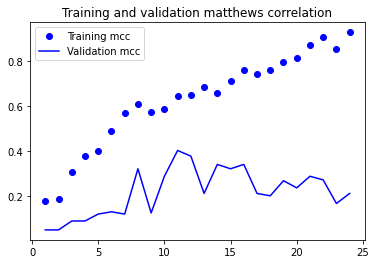

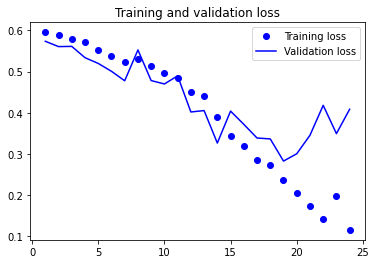

In [ ]:
mcc_titl30 = history_d_titl30.history['matthews_correlation']
val_mcc_titl30 = history_d_titl30.history['val_matthews_correlation']
loss_titl30 = history_d_titl30.history['loss']
val_loss_titl30 = history_d_titl30.history['val_loss']
epochs_titl30 = range(1, len(mcc_titl30) + 1)
plt.plot(epochs_titl30, mcc_titl30, 'bo', label='Training mcc')
plt.plot(epochs_titl30, val_mcc_titl30, 'b', label='Validation mcc')
plt.title('Training and validation matthews correlation')
plt.legend()
plt.figure()
plt.plot(epochs_titl30, loss_titl30, 'bo', label='Training loss')
plt.plot(epochs_titl30, val_loss_titl30, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model_dep_lstm_titl30.load_weights(filepath)
model_dep_lstm_titl30.evaluate(X_test_titl30,Y_test_titl30)
Y_Predicted_titl30 = model_dep_lstm_titl30.predict_classes(X_test_titl30)

27/27 [==============================] - 0s 15ms/step - loss: 1.7858 - accuracy: 0.8685 - matthews_correlation: 0.0106


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
get_metrics(Y_test_titl30,Y_Predicted_titl30)

------------------------------Metrics for model------------------------------
Confusion Matrix:
[[ 13   6]
 [107 733]]
-----------------------------------------------------------------------------
Accuracy: 0.868452
-----------------------------------------------------------------------------
Recall: 0.872619
-----------------------------------------------------------------------------
Matthews Correlation Coeficient: 0.236225
-----------------------------------------------------------------------------
F1-Score: 0.928436


#Testing with more training data
## 30 words 
## Only content
## More data for training of the model

In [ ]:
reals_rdm = pd.concat([treated_reals_05,treated_reals_07,treated_reals_09],axis = 0)
fakes_rdm = pd.concat([treated_fakes_05,treated_fakes_07,treated_fakes_09],axis = 0)

In [ ]:
down_data_rdm = downsample(reals_rdm,fakes_rdm,multiple=True)

In [ ]:
fakes_test = treated_fakes_11.sample(n=2,replace =True)

In [ ]:
reals_test = treated_reals_11.sample(n=round(treated_reals_11.shape[0]*0.1))

In [ ]:
fakes_val = treated_fakes_11.drop([949,958],axis = 0 )

In [ ]:
reals_val = treated_reals_11.drop(list(reals_test.index),axis = 0 )

In [ ]:
dataset_val_rdm = downsample(reals_val,fakes_val)

In [ ]:
dataset_testing_rdm = pd.concat([reals_test,fakes_test])

Epoch 1/100
25/25 [==============================] - 4s 97ms/step - loss: 1.2535 - accuracy: 0.6595 - matthews_correlation: 0.3198 - val_loss: 0.7216 - val_accuracy: 0.5000 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to /saved_models/model_0.h5
Epoch 2/100
25/25 [==============================] - 2s 86ms/step - loss: 0.6667 - accuracy: 0.6143 - matthews_correlation: 0.3223 - val_loss: 0.6500 - val_accuracy: 0.6176 - val_matthews_correlation: 0.1454

Epoch 00002: val_matthews_correlation improved from 0.00000 to 0.14540, saving model to /saved_models/model_0.h5
Epoch 3/100
25/25 [==============================] - 2s 87ms/step - loss: 0.5592 - accuracy: 0.7107 - matthews_correlation: 0.4414 - val_loss: 0.6761 - val_accuracy: 0.5882 - val_matthews_correlation: 0.1454

Epoch 00003: val_matthews_correlation did not improve from 0.14540
Epoch 4/100
25/25 [==============================] - 2s 86ms/step - loss: 0.467

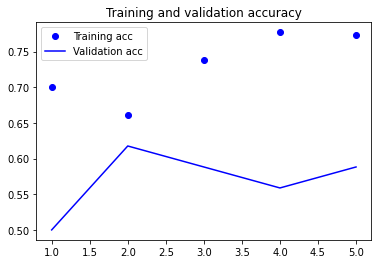

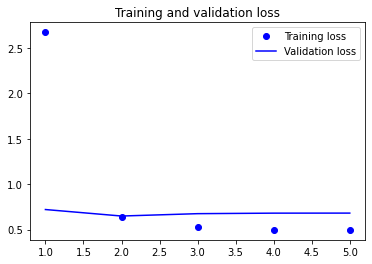

3/3 [==============================] - 0s 13ms/step - loss: 0.8249 - accuracy: 0.3372 - matthews_correlation: 0.0497

0.04969039931893349
Epoch 1/100
25/25 [==============================] - 4s 97ms/step - loss: 0.6704 - accuracy: 0.6261 - matthews_correlation: 0.2976 - val_loss: 0.7168 - val_accuracy: 0.5588 - val_matthews_correlation: 0.1213

Epoch 00001: val_matthews_correlation improved from -inf to 0.12127, saving model to /saved_models/model_1.h5
Epoch 2/100
25/25 [==============================] - 2s 86ms/step - loss: 0.5075 - accuracy: 0.7681 - matthews_correlation: 0.5605 - val_loss: 0.3651 - val_accuracy: 0.8529 - val_matthews_correlation: 0.3444

Epoch 00002: val_matthews_correlation improved from 0.12127 to 0.34442, saving model to /saved_models/model_1.h5
Epoch 3/100
25/25 [==============================] - 2s 87ms/step - loss: 0.3395 - accuracy: 0.8626 - matthews_correlation: 0.7357 - val_loss: 0.3736 - val_accuracy: 0.8235 - val_matthews_correlation: 0.3476

Epoch 00003:

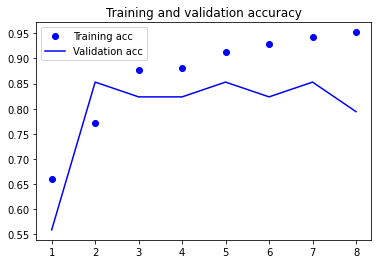

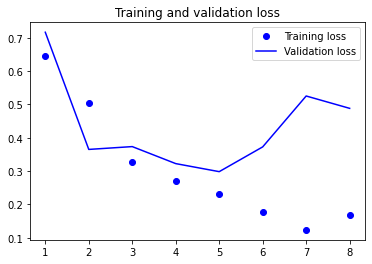

3/3 [==============================] - 0s 16ms/step - loss: 0.0879 - accuracy: 0.9767 - matthews_correlation: 0.3333

0.3333333432674408
Epoch 1/100
25/25 [==============================] - 4s 97ms/step - loss: 0.6677 - accuracy: 0.5990 - matthews_correlation: 0.2256 - val_loss: 0.6686 - val_accuracy: 0.5882 - val_matthews_correlation: 0.1140

Epoch 00001: val_matthews_correlation improved from -inf to 0.11399, saving model to /saved_models/model_2.h5
Epoch 2/100
25/25 [==============================] - 2s 85ms/step - loss: 0.7165 - accuracy: 0.7701 - matthews_correlation: 0.5421 - val_loss: 0.6622 - val_accuracy: 0.6176 - val_matthews_correlation: 0.1545

Epoch 00002: val_matthews_correlation improved from 0.11399 to 0.15452, saving model to /saved_models/model_2.h5
Epoch 3/100
25/25 [==============================] - 2s 86ms/step - loss: 0.5544 - accuracy: 0.7323 - matthews_correlation: 0.4546 - val_loss: 0.7159 - val_accuracy: 0.5882 - val_matthews_correlation: 0.1511

Epoch 00003: 

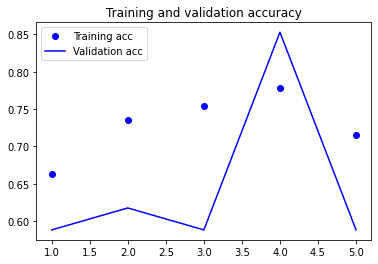

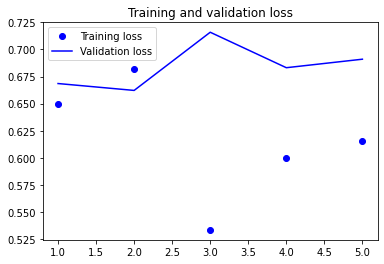

3/3 [==============================] - 0s 11ms/step - loss: 0.3056 - accuracy: 1.0000 - matthews_correlation: 0.3333

0.3333333432674408
Epoch 1/100
25/25 [==============================] - 4s 93ms/step - loss: 0.6491 - accuracy: 0.6694 - matthews_correlation: 0.3325 - val_loss: 0.6723 - val_accuracy: 0.5588 - val_matthews_correlation: 0.0828

Epoch 00001: val_matthews_correlation improved from -inf to 0.08284, saving model to /saved_models/model_3.h5
Epoch 2/100
25/25 [==============================] - 2s 85ms/step - loss: 0.5225 - accuracy: 0.7802 - matthews_correlation: 0.5848 - val_loss: 0.4224 - val_accuracy: 0.8529 - val_matthews_correlation: 0.3765

Epoch 00002: val_matthews_correlation improved from 0.08284 to 0.37654, saving model to /saved_models/model_3.h5
Epoch 3/100
25/25 [==============================] - 2s 82ms/step - loss: 0.3846 - accuracy: 0.8626 - matthews_correlation: 0.7472 - val_loss: 0.3644 - val_accuracy: 0.7941 - val_matthews_correlation: 0.3128

Epoch 00003: 

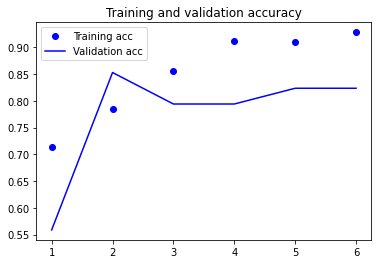

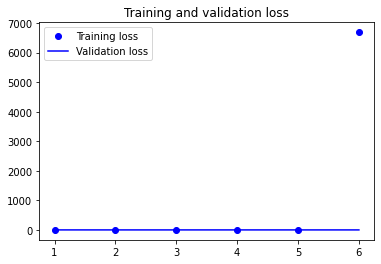

3/3 [==============================] - 0s 12ms/step - loss: 0.3135 - accuracy: 0.9884 - matthews_correlation: 0.3333

0.3333333432674408
Epoch 1/100
25/25 [==============================] - 4s 98ms/step - loss: 0.6799 - accuracy: 0.5630 - matthews_correlation: 0.1728 - val_loss: 0.6671 - val_accuracy: 0.5882 - val_matthews_correlation: 0.1051

Epoch 00001: val_matthews_correlation improved from -inf to 0.10510, saving model to /saved_models/model_4.h5
Epoch 2/100
25/25 [==============================] - 2s 83ms/step - loss: 12.6736 - accuracy: 0.7370 - matthews_correlation: 0.5038 - val_loss: 0.6901 - val_accuracy: 0.5294 - val_matthews_correlation: 0.0652

Epoch 00002: val_matthews_correlation did not improve from 0.10510
Epoch 3/100
25/25 [==============================] - 2s 83ms/step - loss: 0.5906 - accuracy: 0.7451 - matthews_correlation: 0.5124 - val_loss: 0.6795 - val_accuracy: 0.6176 - val_matthews_correlation: 0.1545

Epoch 00003: val_matthews_correlation improved from 0.1051

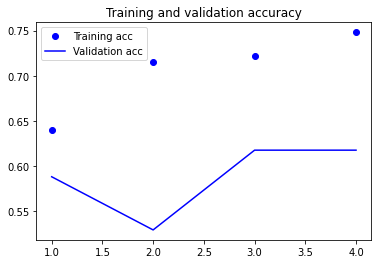

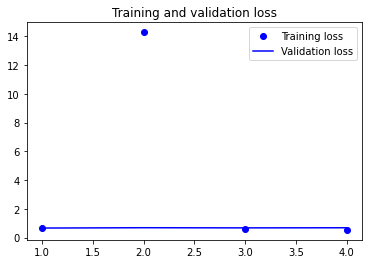

3/3 [==============================] - 0s 12ms/step - loss: 0.7843 - accuracy: 0.3372 - matthews_correlation: 0.0497

0.04969039931893349
Epoch 1/100
25/25 [==============================] - 4s 96ms/step - loss: 0.6613 - accuracy: 0.5962 - matthews_correlation: 0.1495 - val_loss: 0.7010 - val_accuracy: 0.5294 - val_matthews_correlation: 0.0542

Epoch 00001: val_matthews_correlation improved from -inf to 0.05423, saving model to /saved_models/model_5.h5
Epoch 2/100
25/25 [==============================] - 2s 84ms/step - loss: 0.5627 - accuracy: 0.7283 - matthews_correlation: 0.4840 - val_loss: 0.3715 - val_accuracy: 0.8529 - val_matthews_correlation: 0.3852

Epoch 00002: val_matthews_correlation improved from 0.05423 to 0.38524, saving model to /saved_models/model_5.h5
Epoch 3/100
25/25 [==============================] - 2s 85ms/step - loss: 0.5854 - accuracy: 0.8365 - matthews_correlation: 0.6800 - val_loss: 0.6862 - val_accuracy: 0.5882 - val_matthews_correlation: 0.1265

Epoch 00003:

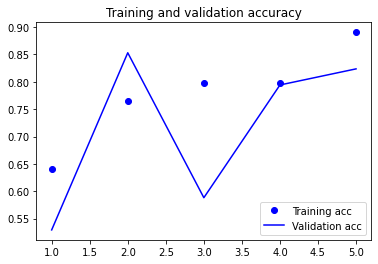

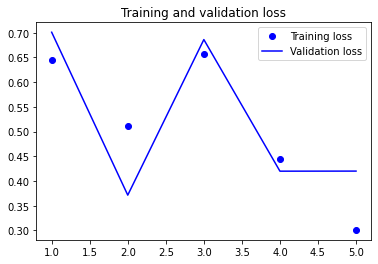

3/3 [==============================] - 0s 12ms/step - loss: 0.1737 - accuracy: 0.9884 - matthews_correlation: 0.3333

0.3333333432674408
Epoch 1/100
25/25 [==============================] - 4s 97ms/step - loss: 0.6703 - accuracy: 0.6295 - matthews_correlation: 0.2473 - val_loss: 0.6496 - val_accuracy: 0.5588 - val_matthews_correlation: 0.0762

Epoch 00001: val_matthews_correlation improved from -inf to 0.07622, saving model to /saved_models/model_6.h5
Epoch 2/100
25/25 [==============================] - 2s 84ms/step - loss: 0.5534 - accuracy: 0.7852 - matthews_correlation: 0.5827 - val_loss: 0.6669 - val_accuracy: 0.5882 - val_matthews_correlation: 0.1265

Epoch 00002: val_matthews_correlation improved from 0.07622 to 0.12654, saving model to /saved_models/model_6.h5
Epoch 3/100
25/25 [==============================] - 2s 86ms/step - loss: 0.4919 - accuracy: 0.8023 - matthews_correlation: 0.6064 - val_loss: 0.5918 - val_accuracy: 0.6471 - val_matthews_correlation: 0.1728

Epoch 00003: 

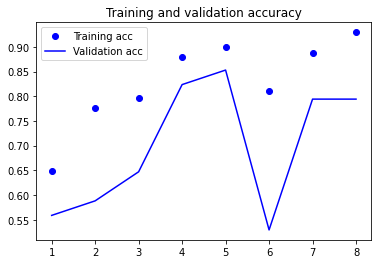

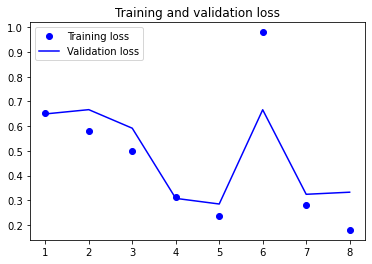

3/3 [==============================] - 0s 12ms/step - loss: 0.1937 - accuracy: 0.9186 - matthews_correlation: 0.3333

0.3333333432674408
Epoch 1/100
25/25 [==============================] - 4s 99ms/step - loss: 0.6601 - accuracy: 0.6812 - matthews_correlation: 0.3597 - val_loss: 0.7134 - val_accuracy: 0.5882 - val_matthews_correlation: 0.1511

Epoch 00001: val_matthews_correlation improved from -inf to 0.15106, saving model to /saved_models/model_7.h5
Epoch 2/100
25/25 [==============================] - 2s 88ms/step - loss: 0.5611 - accuracy: 0.7447 - matthews_correlation: 0.5280 - val_loss: 0.5880 - val_accuracy: 0.8235 - val_matthews_correlation: 0.3589

Epoch 00002: val_matthews_correlation improved from 0.15106 to 0.35887, saving model to /saved_models/model_7.h5
Epoch 3/100
25/25 [==============================] - 2s 86ms/step - loss: 0.4617 - accuracy: 0.7910 - matthews_correlation: 0.5885 - val_loss: 0.4305 - val_accuracy: 0.7941 - val_matthews_correlation: 0.2880

Epoch 00003: 

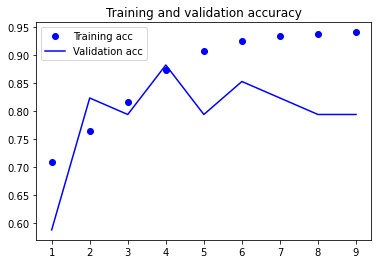

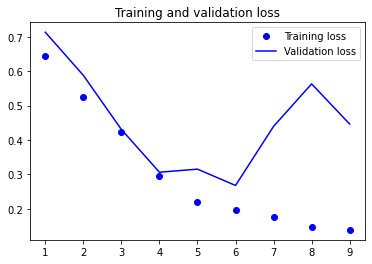

3/3 [==============================] - 0s 12ms/step - loss: 0.1481 - accuracy: 0.9535 - matthews_correlation: 0.3333

0.3333333432674408


In [ ]:
best_rdm = val_down_data(down_data_rdm,dataset_val_rdm,dataset_testing_rdm,max_words=30,mod='c')

In [ ]:
print('Index do melhor datset de treino: %d' %best_rdm)

Index do melhor datset de treino: 2


In [ ]:
X_train_rdm, Y_train_rdm, Train_matrix_rdm, vocab_rdm, train_token_rdm = prepare_full_dataset(down_data_rdm[best_rdm],max_len=30,mode='c')

In [ ]:
X_val_rdm , Y_val_rdm, Val_matrix_rdm, Y_vocab_rdm, useless_rdm = prepare_full_dataset(dataset_val_rdm,token_obj=train_token_rdm,max_len=30,mode='c')

In [ ]:
X_test_rdm , Y_test_rdm , test_matrix_rdm, test_vocab_rdm, useless_2_rdm = prepare_full_dataset(dataset_testing_rdm, token_obj=train_token_rdm,max_len=30,mode='c')

In [ ]:
class MYHyperModel_dep(HyperModel):
    def __init__(self, vocab, matrix,words):
          """
          Args:
              vocab ([int]): [vocabulary size of Embedding]
              matrix ([type]): [word vector matrix for training data, to be used in Embedding]
              words ([int]): [max number of words for input]
          """        
          self.input_shape = vocab
          self.train_matrix = matrix
          self.input_length = words
            
    def build(self,hp):
          """[Creates model to be used in hyperparameter tunning]

          Args:
              hp ([type]): [hyperparameter class]

          Returns:
              []: [Kerastuner model to be optimized]
          """
          model = tf.keras.Sequential()
          model.add(Embedding(self.input_shape, 100, input_length=self.input_length , weights = [self.train_matrix], trainable = False))
          model.add(LSTM(units=hp.Int('units_lstm_1_' , min_value=10, max_value=1100, step=20), activation=hp.Choice('a_lstm_1', values =['relu','tanh','elu','selu','swish']),return_sequences=False))
          for i in range(hp.Int('num_layers_Dense_1_',1, 2)):
            model.add(Dense(units=hp.Int('units_dense_1_' + str(i), min_value=10, max_value=1000, step=20), 
                            activation=hp.Choice('a_dense_1'+str(i), values =['relu','tanh','elu','selu','swish'])))
          
          model.add(Dense(1, activation='sigmoid'))
          model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',
                              values=[1e-2, 1e-3, 1e-4])),
                      loss = 'binary_crossentropy', metrics=['accuracy',matthews_correlation])
          
          return model


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/model_optim/model.h5', 
                                                        monitor='val_matthews_correlation', 
                                                        verbose=0, 
                                                        save_best_only=True, mode='max')

In [ ]:
with tf.device('/device:GPU:0'):
    hypermodel_dep_rdm = MYHyperModel_dep(vocab_rdm,Train_matrix_rdm,words=30)
    tuner_rdm = kt.BayesianOptimization(hypermodel_dep_rdm,
                          objective=kt.Objective("val_matthews_correlation", direction="max"),
                          max_trials=20,
                          num_initial_points=2,
                          directory='/content/optim_lstm_rdm_wrd_13/',
                          project_name='optim_1', seed = 666)
    tuner_rdm.search_space_summary()
    es = tf.keras.callbacks.EarlyStopping(patience=5)
    tuner_rdm.search(X_train_rdm, Y_train_rdm, epochs=200, batch_size=50, 
              validation_data=(X_val_rdm, Y_val_rdm), 
              verbose=0, callbacks=[es, checkpoint])

Search space summary
Default search space size: 6
units_lstm_1_ (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 1100, 'step': 20, 'sampling': None}
a_lstm_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu', 'swish'], 'ordered': False}
num_layers_Dense_1_ (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
units_dense_1_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 1000, 'step': 20, 'sampling': None}
a_dense_10 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu', 'selu', 'swish'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps_dep_rdm = tuner_rdm.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
model_dep_lstm_rdm = tuner_rdm.hypermodel.build(best_hps_dep_rdm)
model_dep_lstm_rdm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           407700    
_________________________________________________________________
lstm (LSTM)                  (None, 510)               1246440   
_________________________________________________________________
dense (Dense)                (None, 310)               158410    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 311       
Total params: 1,812,861
Trainable params: 1,405,161
Non-trainable params: 407,700
_________________________________________________________________


In [ ]:
filepath= '/content/model_rdm.h5'
mc_d = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True,monitor='val_matthews_correlation',mode = 'max')
es_d = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)

history_d_rdm = model_dep_lstm_rdm.fit(X_train_rdm, Y_train_rdm, epochs=200, batch_size=50, 
                    validation_data=(X_val_rdm, Y_val_rdm), 
                    callbacks=[mc_d, es_d])

Epoch 1/200
16/16 [==============================] - 2s 70ms/step - loss: 0.6809 - accuracy: 0.6248 - matthews_correlation: 0.2903 - val_loss: 0.6722 - val_accuracy: 0.5294 - val_matthews_correlation: 0.0592
Epoch 2/200
16/16 [==============================] - 1s 55ms/step - loss: 0.6550 - accuracy: 0.6420 - matthews_correlation: 0.2919 - val_loss: 0.6686 - val_accuracy: 0.5588 - val_matthews_correlation: 0.1195
Epoch 3/200
16/16 [==============================] - 1s 54ms/step - loss: 0.6538 - accuracy: 0.6356 - matthews_correlation: 0.2691 - val_loss: 0.6642 - val_accuracy: 0.5588 - val_matthews_correlation: 0.1195
Epoch 4/200
16/16 [==============================] - 1s 56ms/step - loss: 0.6398 - accuracy: 0.6581 - matthews_correlation: 0.3381 - val_loss: 0.6566 - val_accuracy: 0.5588 - val_matthews_correlation: 0.1195
Epoch 5/200
16/16 [==============================] - 1s 55ms/step - loss: 0.5815 - accuracy: 0.7108 - matthews_correlation: 0.4306 - val_loss: 0.6477 - val_accuracy: 0.

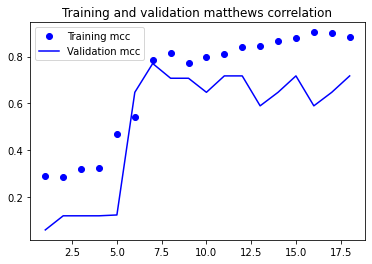

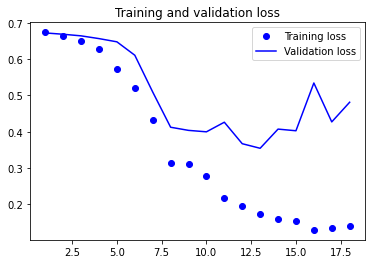

In [ ]:
mcc_rdm = history_d_rdm.history['matthews_correlation']
val_mcc_rdm = history_d_rdm.history['val_matthews_correlation']
loss_rdm = history_d_rdm.history['loss']
val_loss_rdm = history_d_rdm.history['val_loss']
epochs_rdm = range(1, len(mcc_rdm) + 1)
plt.plot(epochs_rdm, mcc_rdm, 'bo', label='Training mcc')
plt.plot(epochs_rdm, val_mcc_rdm, 'b', label='Validation mcc')
plt.title('Training and validation matthews correlation')
plt.legend()
plt.figure()
plt.plot(epochs_rdm, loss_rdm, 'bo', label='Training loss')
plt.plot(epochs_rdm, val_loss_rdm, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model_dep_lstm_rdm.load_weights(filepath)
model_dep_lstm_rdm.evaluate(X_test_rdm,Y_test_rdm)
Y_Predicted_rdm = model_dep_lstm_rdm.predict_classes(X_test_rdm)

3/3 [==============================] - 0s 8ms/step - loss: 0.4346 - accuracy: 0.9651 - matthews_correlation: 0.3333


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
get_metrics(Y_test_rdm,Y_Predicted_rdm)

------------------------------Metrics for model------------------------------
Confusion Matrix:
[[ 2  0]
 [ 3 81]]
-----------------------------------------------------------------------------
Accuracy: 0.965116
-----------------------------------------------------------------------------
Recall: 0.964286
-----------------------------------------------------------------------------
Matthews Correlation Coeficient: 0.621059
-----------------------------------------------------------------------------
F1-Score: 0.981818
